In [26]:
#!pip install -r requirements.txt
import torch
from IMV_LSTM.networks import IMVTensorMultiStepLSTM
from IMV_LSTM.model_prep import prepare_multistep_data
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import importlib
import models.PatchTST_Attention as tshap
importlib.reload(tshap)  
from models.PatchTST_Attention import Model
from data_provider.data_loader import Dataset_Custom
from evaluation.performance import stepwise_errors, get_preds_truths, evaluate
from evaluation.randomize_patchtst import (
    restore_original_attention,
    enable_attention_randomization,
    disable_attention_randomization,
    patchtst_randomization_check
)
from evaluation.randomize_imv_lstm import imvlstm_attention_randomization_check
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import os, re
from evaluation.randomize_imv_lstm import imvlstm_beta_randomization_check
from evaluation.attention_plots import plot_imv_saved_attention
from evaluation.attention_plots import plot_patchtst_temporal


# Model Training

## PatchTST

In [27]:
#%run scripts/PatchTST/weather_int_10.py


In [28]:
#%run scripts/PatchTST/weather_int.py

## IMV LSTM

In [29]:
#%run scripts/IMV_LSTM/weather_int_IMV_LSTM.py \
#  --root_path C:/Users/miche/Documents/PatchTST/PatchTST_supervised/dataset/ \
#  --data_path weather_int.csv \
#  --input_window 576 \
#  --forecast_horizon 144 \
#  --batch_size 128 \
#  --epochs 100 \
#  --lr 3e-4 \
#  --patience 25 \
#  --save_dir ./logs/IMV_weather


# Model Evaluation

## Loading Models from Path

### Prediction Length 10 - PatchTST

In [30]:
class Args_small:
    # random seed
    random_seed = 2021

    # basic config
    is_training = 0
    model_id = 'test'
    model = 'PatchTST_Attention'

    # data loader
    data = 'weather'
    root_path = './dataset'
    data_path = 'weather_int.csv'
    features = 'MS'
    target = 'T (degC)'
    freq = '10T'
    checkpoints = './checkpoints/'

    # forecasting task
    seq_len = 144
    label_len = 10
    pred_len = 10

    # PatchTST
    fc_dropout = 0.1
    head_dropout = 0.0
    patch_len = 12
    stride = 6
    padding_patch = 'end'
    revin = 1
    affine = 0
    subtract_last = 0
    decomposition = 0
    kernel_size = 25
    individual = 1  # True

    # Formers
    embed_type = 0
    enc_in = 7
    dec_in = 7
    c_out = 1
    d_model = 140
    n_heads = 7
    e_layers = 3
    d_layers = 1
    d_ff = 280
    moving_avg = 25
    factor = 1
    distil = True
    dropout = 0.1
    embed = 'timeF'
    activation = 'gelu'
    output_attention = True
    do_predict = False

    # optimization
    num_workers = 0
    itr = 1
    train_epochs = 100
    batch_size = 128
    patience = 5
    learning_rate = 0.0001
    des = 'Exp'
    loss = 'mse'
    lradj = 'type3'
    pct_start = 0.3
    use_amp = False

    # GPU
    use_gpu = True
    gpu = 0
    use_multi_gpu = False
    devices = '0,1,2,3'
    test_flop = False


args_small = Args_small()



In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt_path=(
    "checkpoints/"
    "weather_int_144_10_PatchTST"
    "/checkpoint.pth"
)
ckpt_patch = torch.load(ckpt_path, map_location=device)

state_dict_patch = ckpt_patch.get("model_state_dict", ckpt_patch)
model_patch = Model(args_small)
model_patch = model_patch.float().to(device)
model_patch.load_state_dict(state_dict_patch)
model_patch.eval()


Model(
  (model): PatchTST_backbone(
    (revin_layer): RevIN()
    (padding_patch_layer): ReplicationPad1d((0, 6))
    (backbone): TSTiEncoder(
      (W_P): Linear(in_features=12, out_features=140, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (encoder): TSTEncoder(
        (layers): ModuleList(
          (0): TSTEncoderLayer(
            (self_attn): _MultiheadAttention(
              (W_Q): Linear(in_features=140, out_features=140, bias=True)
              (W_K): Linear(in_features=140, out_features=140, bias=True)
              (W_V): Linear(in_features=140, out_features=140, bias=True)
              (sdp_attn): _ScaledDotProductAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
              )
              (to_out): Sequential(
                (0): Linear(in_features=140, out_features=140, bias=True)
                (1): Dropout(p=0.1, inplace=False)
              )
            )
            (dropout_attn): Dropout(p=0.1, inplace=False)
   

In [32]:
class Args_small_shared:
    # random seed
    random_seed = 2021

    # basic config
    is_training = 0
    model_id = 'test'
    model = 'PatchTST_Attention'

    # data loader
    data = 'weather'
    root_path = './dataset'
    data_path = 'weather_int.csv'
    features = 'MS'
    target = 'T (degC)'
    freq = '10T'
    checkpoints = './checkpoints/'

    # forecasting task
    seq_len = 144
    label_len = 10
    pred_len = 10

    # PatchTST
    fc_dropout = 0.1
    head_dropout = 0.0
    patch_len = 12
    stride = 6
    padding_patch = 'end'
    revin = 1
    affine = 0
    subtract_last = 0
    decomposition = 0
    kernel_size = 25
    individual = 0  # True

    # Formers
    embed_type = 0
    enc_in = 7
    dec_in = 7
    c_out = 1
    d_model = 140
    n_heads = 7
    e_layers = 3
    d_layers = 1
    d_ff = 280
    moving_avg = 25
    factor = 1
    distil = True
    dropout = 0.1
    embed = 'timeF'
    activation = 'gelu'
    output_attention = True
    do_predict = False

    # optimization
    num_workers = 0
    itr = 1
    train_epochs = 100
    batch_size = 128
    patience = 5
    learning_rate = 0.0001
    des = 'Exp'
    loss = 'mse'
    lradj = 'type3'
    pct_start = 0.3
    use_amp = False

    # GPU
    use_gpu = True
    gpu = 0
    use_multi_gpu = False
    devices = '0,1,2,3'
    test_flop = False


args_small_shared = Args_small_shared()
ckpt_path_shared=(
    "checkpoints/"
    "weather_int_144_10_PatchTST_shared"
    "/checkpoint_new.pth"
)
ckpt_patch_shared = torch.load(ckpt_path_shared, map_location=device)

state_dict_patch_shared = ckpt_patch_shared.get("model_state_dict", ckpt_patch_shared)
model_patch_shared = Model(args_small_shared)
model_patch_shared = model_patch_shared.float().to(device)
model_patch_shared.load_state_dict(state_dict_patch_shared)
model_patch_shared.eval()



Model(
  (model): PatchTST_backbone(
    (revin_layer): RevIN()
    (padding_patch_layer): ReplicationPad1d((0, 6))
    (backbone): TSTiEncoder(
      (W_P): Linear(in_features=12, out_features=140, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (encoder): TSTEncoder(
        (layers): ModuleList(
          (0): TSTEncoderLayer(
            (self_attn): _MultiheadAttention(
              (W_Q): Linear(in_features=140, out_features=140, bias=True)
              (W_K): Linear(in_features=140, out_features=140, bias=True)
              (W_V): Linear(in_features=140, out_features=140, bias=True)
              (sdp_attn): _ScaledDotProductAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
              )
              (to_out): Sequential(
                (0): Linear(in_features=140, out_features=140, bias=True)
                (1): Dropout(p=0.1, inplace=False)
              )
            )
            (dropout_attn): Dropout(p=0.1, inplace=False)
   

In [33]:
# 1) Instantiate your test‐time dataset exactly as during training
dataset_test = Dataset_Custom(
    root_path   = "dataset/",
    flag        = "test",                 # pulls the test split
    size        = [144, 10, 10],          # [seq_len, label_len, pred_len]
    features    = "MS",
    data_path   = "weather_int.csv",
    target      = "T (degC)",
    scale       = True,
    timeenc     = 0,
    freq        = "10T",
)

# 2) Wrap in a DataLoader
test_loader_patch = DataLoader(
    dataset_test,
    batch_size  = 128,
    shuffle     = False,
    num_workers = 0,
)


### Prediction Length 10 - IMV-LSTM

In [34]:
# 1) Re-create the model with the same hyper-parameters:
model_IMV = IMVTensorMultiStepLSTM(
    input_dim     = 7,
    output_dim    = 1,
    n_units       = 140,
    forecast_steps= 10
).float().to(device)

# 2) Load the checkpoint (and automatically map to CPU/GPU):
ckpt_path_IMV = "./IMV_weather_144_10/attention_val/checkpoint_latest.pth"
state_IMV = torch.load(ckpt_path_IMV, map_location=device)
model_IMV.load_state_dict(state_IMV['model_state'])

df = pd.read_csv("dataset/weather_int.csv")
target_weather= 'T (degC)'
cols_weather_multi=['p (mbar)', 'Tdew (degC)', 'sh (g/kg)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)', 'T (degC)']
input_window = 144  # instead of 40
forecast_horizon = 10
batch_size_weather=128
X_train_multi, y_train_multi, \
X_val_multi, y_val_multi, \
X_test_multi, y_test_multi, \
input_scaler_multi, target_scaler_multi = prepare_multistep_data(
    df=df,
    input_columns=cols_weather_multi,
    target_column=target_weather,
    input_window=input_window,
    forecast_horizon=forecast_horizon,
    scale_data=True
)
X_train_t_multi = torch.tensor(X_train_multi, dtype=torch.float32)
X_val_t_multi   = torch.tensor(X_val_multi, dtype=torch.float32)
X_test_t_multi  = torch.tensor(X_test_multi, dtype=torch.float32)

y_train_t_multi = torch.tensor(y_train_multi, dtype=torch.float32)
y_val_t_multi   = torch.tensor(y_val_multi, dtype=torch.float32)
y_test_t_multi  = torch.tensor(y_test_multi, dtype=torch.float32)


test_loader_IMV = DataLoader(
    TensorDataset(X_test_t_multi, y_test_t_multi),
    shuffle=False,
    batch_size=batch_size_weather
)

### Prediction Length 72 - PatchTST

In [35]:
class Args_mid:
    # random seed
    random_seed = 2021

    # basic config
    is_training = 0
    model_id = 'test'
    model = 'PatchTST_Attention'

    # data loader
    data = 'weather'
    root_path = './dataset'
    data_path = 'weather_int.csv'
    features = 'MS'
    target = 'T (degC)'
    freq = '10T'
    checkpoints = './checkpoints/'

    # forecasting task
    seq_len = 432
    label_len = 72
    pred_len = 72

    # PatchTST
    fc_dropout = 0.2
    head_dropout = 0.0
    patch_len = 24
    stride = 12
    padding_patch = 'end'
    revin = 1
    affine = 0
    subtract_last = 0
    decomposition = 0
    kernel_size = 25
    individual = 1  # True

    # Formers
    embed_type = 0
    enc_in = 7
    dec_in = 7
    c_out = 1
    d_model = 140
    n_heads = 7
    e_layers = 3
    d_layers = 1
    d_ff = 280
    moving_avg = 25
    factor = 1
    distil = True
    dropout = 0.2
    embed = 'timeF'
    activation = 'gelu'
    output_attention = True
    do_predict = False

    # optimization
    num_workers = 0
    itr = 1
    train_epochs = 100
    batch_size = 128
    patience = 5
    learning_rate = 0.0003
    des = 'Exp'
    loss = 'mse'
    lradj = 'type3'
    pct_start = 0.3
    use_amp = False

    # GPU
    use_gpu = True
    gpu = 0
    use_multi_gpu = False
    devices = '0,1,2,3'
    test_flop = False


args_mid = Args_mid()

import os
import torch

# 1) Set device and paths
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt_dir_mid  = (
    "checkpoints/"
    "weather_int_432_72_PatchTST"
)
ckpt_path_mid = os.path.join(ckpt_dir_mid, "checkpoint.pth")  # or checkpoint_latest.pth

# sanity check
assert os.path.isfile(ckpt_path_mid), f"Checkpoint not found: {ckpt_path_mid}"

# 2) Load the checkpoint
ckpt_mid = torch.load(ckpt_path_mid, map_location=device)

# 3) Extract the state dict (fallback to the whole object if it isn’t a dict)
state_dict_patch_mid = ckpt_mid.get("model_state", ckpt_mid)

# 4) Rebuild & load your model
model_patch_mid = Model(args_mid).to(device).float()
model_patch_mid.load_state_dict(state_dict_patch_mid)
model_patch_mid.eval()


Model(
  (model): PatchTST_backbone(
    (revin_layer): RevIN()
    (padding_patch_layer): ReplicationPad1d((0, 12))
    (backbone): TSTiEncoder(
      (W_P): Linear(in_features=24, out_features=140, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (encoder): TSTEncoder(
        (layers): ModuleList(
          (0): TSTEncoderLayer(
            (self_attn): _MultiheadAttention(
              (W_Q): Linear(in_features=140, out_features=140, bias=True)
              (W_K): Linear(in_features=140, out_features=140, bias=True)
              (W_V): Linear(in_features=140, out_features=140, bias=True)
              (sdp_attn): _ScaledDotProductAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
              )
              (to_out): Sequential(
                (0): Linear(in_features=140, out_features=140, bias=True)
                (1): Dropout(p=0.2, inplace=False)
              )
            )
            (dropout_attn): Dropout(p=0.2, inplace=False)
  

In [36]:
class Args_mid_shared:
    # random seed
    random_seed = 2021

    # basic config
    is_training = 0
    model_id = 'test'
    model = 'PatchTST_Attention'

    # data loader
    data = 'weather'
    root_path = './dataset'
    data_path = 'weather_int.csv'
    features = 'MS'
    target = 'T (degC)'
    freq = '10T'
    checkpoints = './checkpoints/'

    # forecasting task
    seq_len = 432
    label_len = 72
    pred_len = 72

    # PatchTST
    fc_dropout = 0.2
    head_dropout = 0.0
    patch_len = 24
    stride = 12
    padding_patch = 'end'
    revin = 1
    affine = 0
    subtract_last = 0
    decomposition = 0
    kernel_size = 25
    individual = 0  # True

    # Formers
    embed_type = 0
    enc_in = 7
    dec_in = 7
    c_in = 7  # which is 7
    c_out = 1
    d_model = 140
    n_heads = 7
    e_layers = 3
    d_layers = 1
    d_ff = 280
    moving_avg = 25
    factor = 1
    distil = True
    dropout = 0.2
    embed = 'timeF'
    activation = 'gelu'
    output_attention = True
    do_predict = False

    # optimization
    num_workers = 0
    itr = 1
    train_epochs = 100
    batch_size = 128
    patience = 5
    learning_rate = 0.0003
    des = 'Exp'
    loss = 'mse'
    lradj = 'type3'
    pct_start = 0.3
    use_amp = False

    # GPU
    use_gpu = True
    gpu = 0
    use_multi_gpu = False
    devices = '0,1,2,3'
    test_flop = False


args_mid_shared = Args_mid_shared()


# 1) Set device and paths
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt_dir_mid_shared  = (
    "checkpoints/"
    "weather_int_432_72_PatchTST_shared"
)
ckpt_path_mid_shared = os.path.join(ckpt_dir_mid_shared, "checkpoint_new.pth")  # or checkpoint_latest.pth

# sanity check
assert os.path.isfile(ckpt_path_mid_shared), f"Checkpoint not found: {ckpt_path_mid_shared}"

# 2) Load the checkpoint
ckpt_mid_shared = torch.load(ckpt_path_mid_shared, map_location=device)

# 3) Extract the state dict (fallback to the whole object if it isn’t a dict)
state_dict_patch_mid_shared = ckpt_mid_shared.get("model_state", ckpt_mid_shared)

# 4) Rebuild & load your model
model_patch_mid_shared = Model(args_mid_shared).to(device).float()
model_patch_mid_shared.load_state_dict(state_dict_patch_mid_shared, strict=False)
model_patch_mid_shared.eval()


Model(
  (model): PatchTST_backbone(
    (revin_layer): RevIN()
    (padding_patch_layer): ReplicationPad1d((0, 12))
    (backbone): TSTiEncoder(
      (W_P): Linear(in_features=24, out_features=140, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (encoder): TSTEncoder(
        (layers): ModuleList(
          (0): TSTEncoderLayer(
            (self_attn): _MultiheadAttention(
              (W_Q): Linear(in_features=140, out_features=140, bias=True)
              (W_K): Linear(in_features=140, out_features=140, bias=True)
              (W_V): Linear(in_features=140, out_features=140, bias=True)
              (sdp_attn): _ScaledDotProductAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
              )
              (to_out): Sequential(
                (0): Linear(in_features=140, out_features=140, bias=True)
                (1): Dropout(p=0.2, inplace=False)
              )
            )
            (dropout_attn): Dropout(p=0.2, inplace=False)
  

In [37]:
# 1) Instantiate your test‐time dataset exactly as during training
dataset_test_patch_mid = Dataset_Custom(
    root_path   = "dataset/",
    flag        = "test",                 # pulls the test split
    size        = [432, 72, 72],          # [seq_len, label_len, pred_len]
    features    = "MS",
    data_path   = "weather_int.csv",
    target      = "T (degC)",
    scale       = True,
    timeenc     = 0,
    freq        = "10T",
)

# 2) Wrap in a DataLoader
test_loader_patch_mid = DataLoader(
    dataset_test_patch_mid,
    batch_size  = 128,
    shuffle     = False,
    num_workers = 0,
)


### Prediction Length 72 - IMV-LSTM 

In [38]:
# 1) Re-create the model with the same hyper-parameters:
model_IMV_mid = IMVTensorMultiStepLSTM(
    input_dim     = 7,
    output_dim    = 1,
    n_units       = 140,
    forecast_steps= 72
).float().to(device)

# 2) Load the checkpoint (and automatically map to CPU/GPU):
ckpt_path_IMV_mid = "./IMV_weather_432_72/attention_val/checkpoint_latest.pth"
state_IMV_mid = torch.load(ckpt_path_IMV_mid, map_location=device)
model_IMV_mid.load_state_dict(state_IMV_mid['model_state'])

df = pd.read_csv("dataset/weather_int.csv")
target_weather= 'T (degC)'
cols_weather_multi=['p (mbar)', 'Tdew (degC)', 'sh (g/kg)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)', 'T (degC)']
input_window_mid = 432   # instead of 40
forecast_horizon_mid = 72
batch_size_weather=128
X_train_mid, y_train_mid, \
X_val_mid, y_val_mid, \
X_test_mid, y_test_mid, \
input_scaler_mid, target_scaler_mid = prepare_multistep_data(
    df=df,
    input_columns=cols_weather_multi,
    target_column=target_weather,
    input_window=input_window_mid,
    forecast_horizon=forecast_horizon_mid,
    scale_data=True
)
X_train_t_mid = torch.tensor(X_train_mid, dtype=torch.float32)
X_val_t_mid   = torch.tensor(X_val_mid, dtype=torch.float32)
X_test_t_mid  = torch.tensor(X_test_mid, dtype=torch.float32)

y_train_t_mid = torch.tensor(y_train_mid, dtype=torch.float32)
y_val_t_mid   = torch.tensor(y_val_mid, dtype=torch.float32)
y_test_t_mid  = torch.tensor(y_test_mid, dtype=torch.float32)


test_loader_IMV_mid = DataLoader(
    TensorDataset(X_test_t_mid, y_test_t_mid),
    shuffle=False,
    batch_size=batch_size_weather,
    num_workers = 0
)

### Prediction Length 144 - PatchTST

In [39]:
class Args_long:
    # random seed
    random_seed = 2021

    # basic config
    is_training = 0
    model_id = 'weather_int'
    model = 'PatchTST_Attention'

    # data loader
    data = 'custom'
    root_path = './dataset'
    data_path = 'weather_int.csv'
    features = 'MS'
    target = 'T (degC)'
    freq = '10T'
    checkpoints = './checkpoints/'

    # forecasting task
    seq_len = 576     # 4 days of history (576 × 10 min)
    label_len = 72   # decoder sees last 1 day (144 steps)
    pred_len = 144    # forecast horizon = 1 day

    # PatchTST-specific
    fc_dropout = 0.3
    head_dropout = 0.0
    patch_len = 48   # 4 h patches (24 × 10 min)
    stride = 24       # 50% overlap
    padding_patch = 'end'
    revin = 1
    affine = 0
    subtract_last = 0
    decomposition = 0
    kernel_size = 25
    individual = 1  # True

    # Transformer backbone
    embed_type = 0
    enc_in = 7
    dec_in = 7
    c_out = 1
    d_model = 140
    n_heads = 7
    e_layers = 3
    d_layers = 1
    d_ff = 560
    moving_avg = 25
    factor = 1
    distil = True
    dropout = 0.2
    embed = 'timeF'
    activation = 'gelu'
    output_attention = True
    do_predict = False

    # optimization
    num_workers = 0
    itr = 1
    train_epochs = 100
    batch_size = 128
    patience = 25
    learning_rate = 1e-4
    des = 'Exp'
    loss = 'mse'
    lradj = 'type3'
    pct_start = 0.5
    use_amp = False

    # GPU
    use_gpu = True
    gpu = 0
    use_multi_gpu = False
    devices = '0'
    test_flop = False

args_long = Args_long()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt_path_long=(
    "checkpoints/"
    "weather_int_576_144_PatchTST"
    "/checkpoint.pth"
)

ckpt_patch_long = torch.load(ckpt_path_long, map_location=device)

state_dict_patch_long = ckpt_patch_long.get("model_state_dict", ckpt_patch_long)
model_patch_long = Model(args_long)
model_patch_long = model_patch_long.float().to(device)
model_patch_long.load_state_dict(state_dict_patch_long)
model_patch_long.eval()

Model(
  (model): PatchTST_backbone(
    (revin_layer): RevIN()
    (padding_patch_layer): ReplicationPad1d((0, 24))
    (backbone): TSTiEncoder(
      (W_P): Linear(in_features=48, out_features=140, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (encoder): TSTEncoder(
        (layers): ModuleList(
          (0): TSTEncoderLayer(
            (self_attn): _MultiheadAttention(
              (W_Q): Linear(in_features=140, out_features=140, bias=True)
              (W_K): Linear(in_features=140, out_features=140, bias=True)
              (W_V): Linear(in_features=140, out_features=140, bias=True)
              (sdp_attn): _ScaledDotProductAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
              )
              (to_out): Sequential(
                (0): Linear(in_features=140, out_features=140, bias=True)
                (1): Dropout(p=0.2, inplace=False)
              )
            )
            (dropout_attn): Dropout(p=0.2, inplace=False)
  

In [40]:
class Args_long_shared:
    # random seed
    random_seed = 2021

    # basic config
    is_training = 0
    model_id = 'weather_int'
    model = 'PatchTST_Attention'

    # data loader
    data = 'custom'
    root_path = './dataset'
    data_path = 'weather_int.csv'
    features = 'MS'
    target = 'T (degC)'
    freq = '10T'
    checkpoints = './checkpoints/'

    # forecasting task
    seq_len = 576     # 4 days of history (576 × 10 min)
    label_len = 72   # decoder sees last 1 day (144 steps)
    pred_len = 144    # forecast horizon = 1 day

    # PatchTST-specific
    fc_dropout = 0.2
    head_dropout = 0.0
    patch_len = 48    # 4 h patches (24 × 10 min)
    stride = 24       # 50% overlap
    padding_patch = 'end'
    revin = 1
    affine = 0
    subtract_last = 0
    decomposition = 0
    kernel_size = 25
    individual = 0  # True

    # Transformer backbone
    embed_type = 0
    enc_in = 7
    dec_in = 7
    c_out = 1
    d_model = 140
    n_heads = 7
    e_layers = 3
    d_layers = 1
    d_ff = 560
    moving_avg = 25
    factor = 1
    distil = True
    dropout = 0.2
    embed = 'timeF'
    activation = 'gelu'
    output_attention = True
    do_predict = False

    # optimization
    num_workers = 0
    itr = 1
    train_epochs = 100
    batch_size = 128
    patience = 25
    learning_rate = 1e-4
    des = 'Exp'
    loss = 'mse'
    lradj = 'type3'
    pct_start = 0.3
    use_amp = False

    # GPU
    use_gpu = True
    gpu = 0
    use_multi_gpu = False
    devices = '0'
    test_flop = False

args_long_shared = Args_long_shared()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt_path_long_shared=(
    "checkpoints/"
    "weather_int_576_144_PatchTST_shared"
    "/checkpoint_new.pth"
)

ckpt_patch_long_shared = torch.load(ckpt_path_long_shared, map_location=device)

state_dict_patch_long_shared = ckpt_patch_long_shared.get("model_state_dict", ckpt_patch_long_shared)
model_patch_long_shared = Model(args_long_shared)
model_patch_long_shared = model_patch_long_shared.float().to(device)
model_patch_long_shared.load_state_dict(state_dict_patch_long_shared)
model_patch_long_shared.eval()

Model(
  (model): PatchTST_backbone(
    (revin_layer): RevIN()
    (padding_patch_layer): ReplicationPad1d((0, 24))
    (backbone): TSTiEncoder(
      (W_P): Linear(in_features=48, out_features=140, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (encoder): TSTEncoder(
        (layers): ModuleList(
          (0): TSTEncoderLayer(
            (self_attn): _MultiheadAttention(
              (W_Q): Linear(in_features=140, out_features=140, bias=True)
              (W_K): Linear(in_features=140, out_features=140, bias=True)
              (W_V): Linear(in_features=140, out_features=140, bias=True)
              (sdp_attn): _ScaledDotProductAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
              )
              (to_out): Sequential(
                (0): Linear(in_features=140, out_features=140, bias=True)
                (1): Dropout(p=0.2, inplace=False)
              )
            )
            (dropout_attn): Dropout(p=0.2, inplace=False)
  

In [41]:
# 1) Instantiate your long-horizon test dataset exactly as during training
dataset_test_patch_long = Dataset_Custom(
    root_path   = "dataset/",           # relative to cwd
    flag        = "test",               # pulls the test split
    size        = [576, 72, 144],      # [seq_len, label_len, pred_len]
    features    = "MS",
    data_path   = "weather_int.csv",
    target      = "T (degC)",
    scale       = True,
    timeenc     = 0,
    freq        = "10T",
)

# 2) Wrap in a DataLoader
test_loader_patch_long = DataLoader(
    dataset_test_patch_long,
    batch_size  = 128,
    shuffle     = False,
    num_workers = 0,
)


### Prediction Length 144 - IMV-LSTM

In [42]:
# 1) Re-create your long-horizon IMV‐LSTM model
model_IMV_long = IMVTensorMultiStepLSTM(
    input_dim      = 7,
    output_dim     = 1,
    n_units        = 140,
    forecast_steps = 144        # forecast_horizon_long
).float().to(device)

# 2) Load the long-horizon checkpoint
ckpt_path_IMV_long = "./IMV_weather_576_144/attention_val/checkpoint_latest_.pth"
state_IMV_long= torch.load(ckpt_path_IMV_long, map_location=device)
model_IMV_long.load_state_dict(state_IMV_long['model_state'])

# 3) Prepare your data for the long run
df = pd.read_csv("dataset/weather_int.csv")
target_weather      = 'T (degC)'
cols_weather_multi  = [
    'p (mbar)', 'Tdew (degC)', 'sh (g/kg)',
    'wv (m/s)', 'max. wv (m/s)', 'wd (deg)', 'T (degC)'
]
input_window_long     = 576   # e.g. 4 days of history (576×10 min)
forecast_horizon_long = 144   # 1 day ahead (144×10 min)
batch_size_weather    = 128

X_train_long, y_train_long, \
X_val_long,   y_val_long,   \
X_test_long,  y_test_long,  \
in_scaler_long, out_scaler_long = prepare_multistep_data(
    df=df,
    input_columns = cols_weather_multi,
    target_column = target_weather,
    input_window  = input_window_long,
    forecast_horizon = forecast_horizon_long,
    scale_data    = True
)

# 4) Tensor‐ify
X_test_t_long = torch.tensor(X_test_long, dtype=torch.float32)
y_test_t_long = torch.tensor(y_test_long, dtype=torch.float32)

# 5) Long‐horizon test DataLoader
test_loader_IMV_long = DataLoader(
    TensorDataset(X_test_t_long, y_test_t_long),
    shuffle     = False,
    batch_size  = batch_size_weather,
    num_workers = 0
)


### Scaler

In [43]:
# Extract only the target column (same as in your dataset)
df = pd.read_csv("dataset/weather_int.csv")
target = 'T (degC)'
data = df[[target]].values

# Match train split logic (70% of total rows)
num_train = int(len(data) * 0.7)
train_data = data[:num_train]

# Recreate and fit the scaler
scaler = StandardScaler()
scaler.fit(train_data)


StandardScaler()

## Results

### MSE, RMSE, MAE

In [19]:
## ── 8) RUN & DISPLAY ─────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import evaluation.performance as perf
perf.device = device
results = []
for name, mdl, loader in [
    ("PatchTST",           model_patch,      test_loader_patch),
    ("PatchTST-shared",    model_patch_shared,      test_loader_patch),
    ("PatchTST-Mid",       model_patch_mid,  test_loader_patch_mid),
    ("PatchTST-Mid-shared",       model_patch_mid_shared,  test_loader_patch_mid),
    ("PatchTST-Long",      model_patch_long, test_loader_patch_long),
    ("PatchTST-Long-shared",      model_patch_long_shared, test_loader_patch_long),
    ("IMV-LSTM",           model_IMV,        test_loader_IMV),
    ("IMV-LSTM-Mid",       model_IMV_mid,    test_loader_IMV_mid),
    ("IMV-LSTM-Long",      model_IMV_long,   test_loader_IMV_long),
]:
    metrics = evaluate(mdl, loader, target_channel=-1,scaler=None)
    metrics["Model"] = name
    results.append(metrics)

df = pd.DataFrame(results)
print(df.to_markdown(index=False))

|        MSE |      RMSE |       MAE | Model                |
|-----------:|----------:|----------:|:---------------------|
| 0.00556475 | 0.0745972 | 0.0485637 | PatchTST             |
| 0.0062741  | 0.0792092 | 0.0544449 | PatchTST-shared      |
| 0.0593334  | 0.243585  | 0.176785  | PatchTST-Mid         |
| 0.0605149  | 0.245998  | 0.182804  | PatchTST-Mid-shared  |
| 0.0956744  | 0.309313  | 0.228432  | PatchTST-Long        |
| 0.108044   | 0.3287    | 0.248639  | PatchTST-Long-shared |
| 0.0106237  | 0.103071  | 0.0743043 | IMV-LSTM             |
| 0.155664   | 0.394543  | 0.311376  | IMV-LSTM-Mid         |
| 0.317611   | 0.56357   | 0.464252  | IMV-LSTM-Long        |


In [20]:
import importlib
import evaluation.performance as perf      # bring in the module object
importlib.reload(perf)    
from evaluation.performance import get_preds_truths
from evaluation.performance     import stepwise_errors

# 1) Get preds & trues for every model / horizon
patch_preds,      patch_trues      = get_preds_truths(model_patch,      test_loader_patch,      device, args=args_small)
patch_preds_mid,  patch_trues_mid  = get_preds_truths(model_patch_mid,  test_loader_patch_mid,  device, args=args_mid)
patch_preds_long, patch_trues_long = get_preds_truths(model_patch_long, test_loader_patch_long, device, args=args_long)

patch_preds_shared,      patch_trues_shared      = get_preds_truths(model_patch_shared,      test_loader_patch,      device, args=args_small_shared)
patch_preds_mid_shared,  patch_trues_mid_shared  = get_preds_truths(model_patch_mid_shared,  test_loader_patch_mid,  device, args=args_mid_shared)
patch_preds_long_shared, patch_trues_long_shared = get_preds_truths(model_patch_long_shared, test_loader_patch_long, device, args=args_long_shared)

imv_preds,        imv_trues        = get_preds_truths(model_IMV,        test_loader_IMV,        device)
imv_preds_mid,    imv_trues_mid    = get_preds_truths(model_IMV_mid,    test_loader_IMV_mid,    device)
imv_preds_long,   imv_trues_long   = get_preds_truths(model_IMV_long,   test_loader_IMV_long,   device)







In [21]:
# 2) Now compute per-step RMSE/MAE
patch_rmse,      patch_mae      = stepwise_errors(patch_preds,      patch_trues)
patch_rmse_mid,  patch_mae_mid  = stepwise_errors(patch_preds_mid,  patch_trues_mid)
patch_rmse_long, patch_mae_long = stepwise_errors(patch_preds_long, patch_trues_long)

patch_rmse_shared,      patch_mae_shared      = stepwise_errors(patch_preds_shared,      patch_trues_shared)
patch_rmse_mid_shared,  patch_mae_mid_shared  = stepwise_errors(patch_preds_mid_shared,  patch_trues_mid_shared)
patch_rmse_long_shared, patch_mae_long_shared = stepwise_errors(patch_preds_long_shared, patch_trues_long_shared)

imv_rmse,        imv_mae        = stepwise_errors(imv_preds,        imv_trues)
imv_rmse_mid,    imv_mae_mid    = stepwise_errors(imv_preds_mid,    imv_trues_mid)
imv_rmse_long,   imv_mae_long   = stepwise_errors(imv_preds_long,   imv_trues_long)

In [23]:
#patch_preds_mid_shared,  patch_trues_mid_shared  = get_preds_truths(model_patch_mid_shared,  test_loader_patch_mid,  device)
#patch_rmse_mid_shared,  patch_mae_mid_shared  = stepwise_errors(patch_preds_mid_shared,  patch_trues_mid_shared)
#patch_preds_long_shared, patch_trues_long_shared = get_preds_truths(model_patch_long_shared, test_loader_patch_long, device)
#patch_preds_long, patch_trues_long = get_preds_truths(model_patch_long, test_loader_patch_long, device)
#patch_rmse_long, patch_mae_long = stepwise_errors(patch_preds_long, patch_trues_long)
#patch_rmse_long_shared, patch_mae_long_shared = stepwise_errors(patch_preds_long_shared, patch_trues_long_shared)

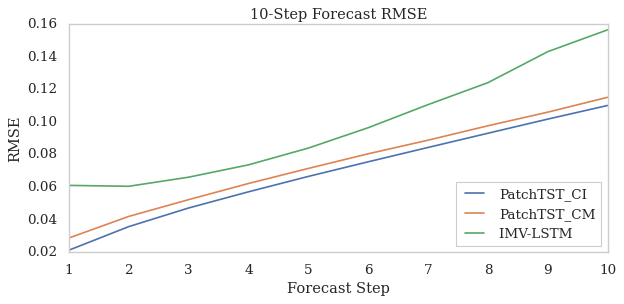

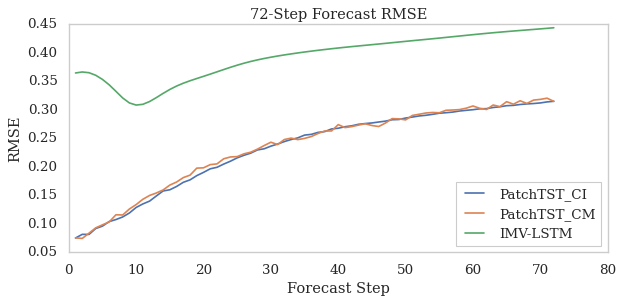

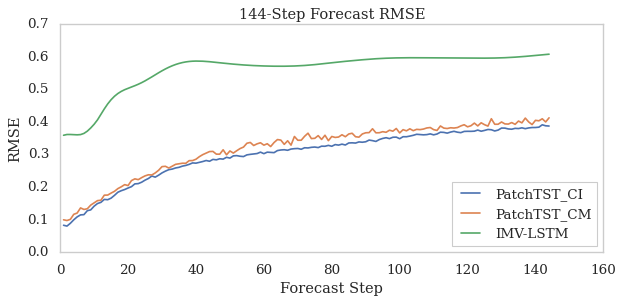

In [50]:
# 2) Short‐horizon plot (pred_len=10)
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler('color',
    ['#004488','#DDAA33','#BB5566','#66BBEE'])
import seaborn as sns

sns.set_theme(
    style="whitegrid",      # white background with grid lines
    palette="deep",         # nice default color palette
    font="serif",           # use a serif font
    font_scale=1.1          # make text a bit larger
)

steps_short = np.arange(1, len(patch_rmse) + 1)
plt.figure(figsize=(8,4))
plt.plot(steps_short, patch_rmse, marker='', label='PatchTST_CI')
plt.plot(steps_short, patch_rmse_shared, marker='', label='PatchTST_CM')
plt.plot(steps_short, imv_rmse,   marker='', label='IMV-LSTM ')
plt.xlabel('Forecast Step')
plt.ylabel('RMSE')
plt.title('10-Step Forecast RMSE')
plt.legend(loc="lower right")
plt.grid(False)
#plt.style.use("classic") 
plt.tight_layout()
plt.savefig("RMSE_forecast_steps_10.pdf", dpi=300)
plt.show()

sns.set_theme(
    style="whitegrid",      # white background with grid lines
    palette="deep",         # nice default color palette
    font="serif",           # use a serif font
    font_scale=1.1          # make text a bit larger
)
# 4) Mid-horizon plot (pred_len=72)
steps_mid = np.arange(1, len(patch_rmse_mid) + 1)

plt.figure(figsize=(8,4))
plt.plot(steps_mid, patch_rmse_mid, marker='', label='PatchTST_CI')
plt.plot(steps_mid, patch_rmse_mid_shared, marker='', label='PatchTST_CM')
plt.plot(steps_mid, imv_rmse_mid,   marker='', label='IMV-LSTM')
plt.xlabel('Forecast Step')
plt.ylabel('RMSE')
plt.title('72-Step Forecast RMSE')
plt.legend(loc="lower right")
plt.grid(False)
plt.tight_layout()
plt.savefig("RMSE_forecast_steps_72.pdf", dpi=300)
plt.show()
sns.set_theme(
    style="whitegrid",      # white background with grid lines
    palette="deep",         # nice default color palette
    font="serif",           # use a serif font
    font_scale=1.1          # make text a bit larger
)
# 3) Long‐horizon plot (pred_len=144)
steps_long = np.arange(1, len(patch_rmse_long) + 1)

plt.figure(figsize=(8,4))
plt.plot(steps_long, patch_rmse_long, marker='', label='PatchTST_CI')
plt.plot(steps_long, patch_rmse_long_shared, marker='', label='PatchTST_CM')
plt.plot(steps_long, imv_rmse_long,   marker='', label='IMV-LSTM')
plt.xlabel('Forecast Step')
plt.ylabel('RMSE')
plt.title('144-Step Forecast RMSE')
plt.legend(loc="lower right")
plt.grid(False)
plt.tight_layout()
plt.savefig("RMSE_forecast_steps_144.pdf", dpi=300)
plt.show()


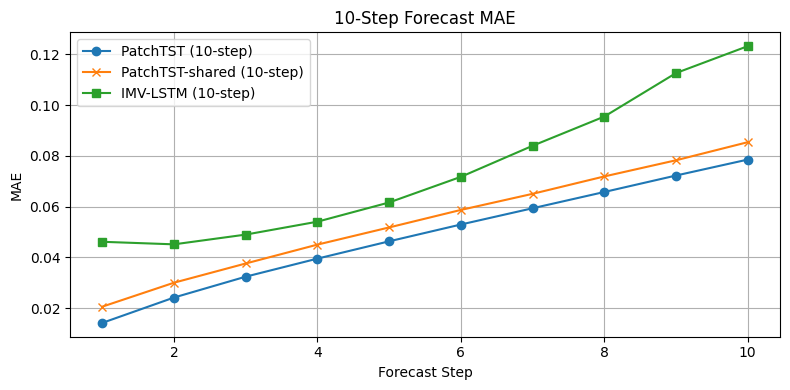

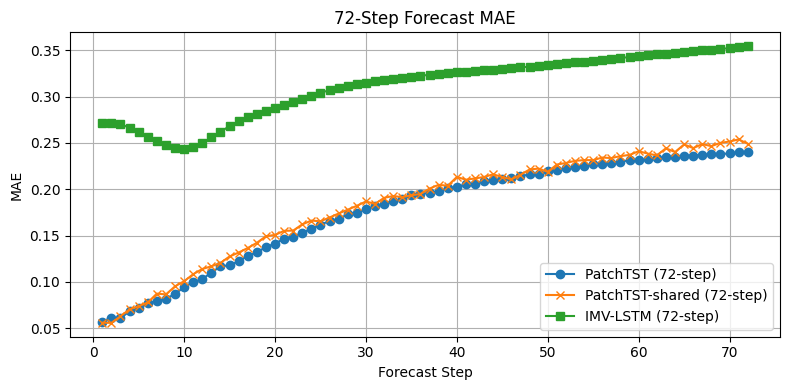

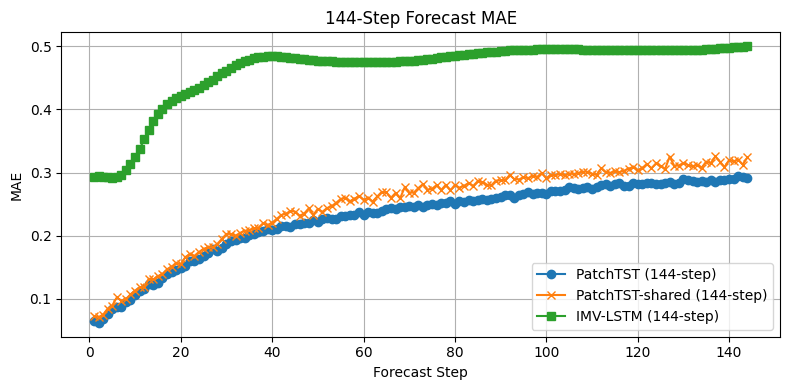

In [23]:

# 2) Short‐horizon plot (pred_len=10)
#steps_short = np.arange(1, len(patch_mae) + 1)

plt.figure(figsize=(8,4))
plt.plot(steps_short, patch_mae, marker='o', label='PatchTST (10-step)')
plt.plot(steps_short, patch_mae_shared, marker='x', label='PatchTST-shared (10-step)')
plt.plot(steps_short, imv_mae,   marker='s', label='IMV-LSTM (10-step)')
plt.xlabel('Forecast Step')
plt.ylabel('MAE')
plt.title('10-Step Forecast MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4) Mid‐horizon plot (pred_len=72)
steps_mid = np.arange(1, len(patch_mae_mid) + 1)

plt.figure(figsize=(8,4))
plt.plot(steps_mid, patch_mae_mid, marker='o', label='PatchTST (72-step)')
plt.plot(steps_mid, patch_mae_mid_shared, marker='x', label='PatchTST-shared (72-step)')
plt.plot(steps_mid, imv_mae_mid,   marker='s', label='IMV-LSTM (72-step)')
plt.xlabel('Forecast Step')
plt.ylabel('MAE')
plt.title('72-Step Forecast MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) Long‐horizon plot (pred_len=144)
steps_long = np.arange(1, len(patch_mae_long) + 1)

plt.figure(figsize=(8,4))
plt.plot(steps_long, patch_mae_long, marker='o', label='PatchTST (144-step)')
plt.plot(steps_long, patch_mae_long_shared, marker='x', label='PatchTST-shared (144-step)')
plt.plot(steps_long, imv_mae_long,   marker='s', label='IMV-LSTM (144-step)')
plt.xlabel('Forecast Step')
plt.ylabel('MAE')
plt.title('144-Step Forecast MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Attention Plots

In [47]:
#%cd C:\Users\miche\Documents\XAI\PatchTST_supervised

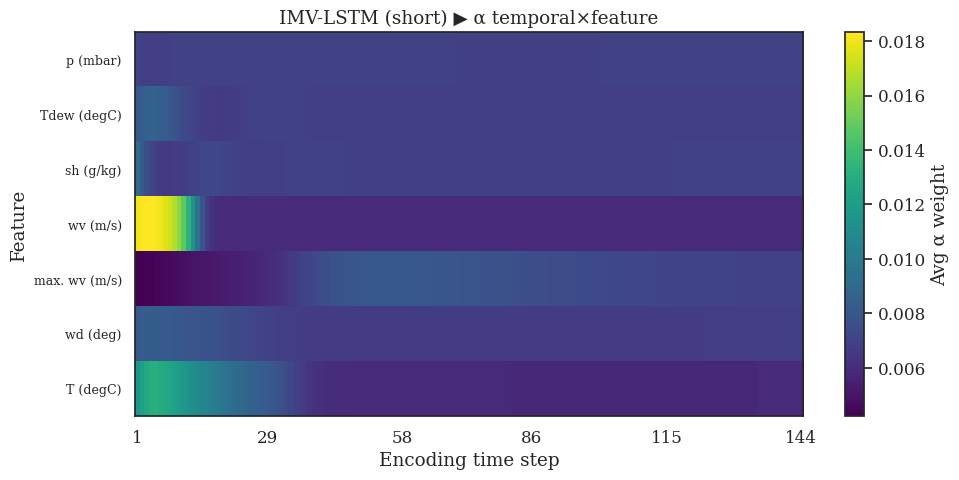

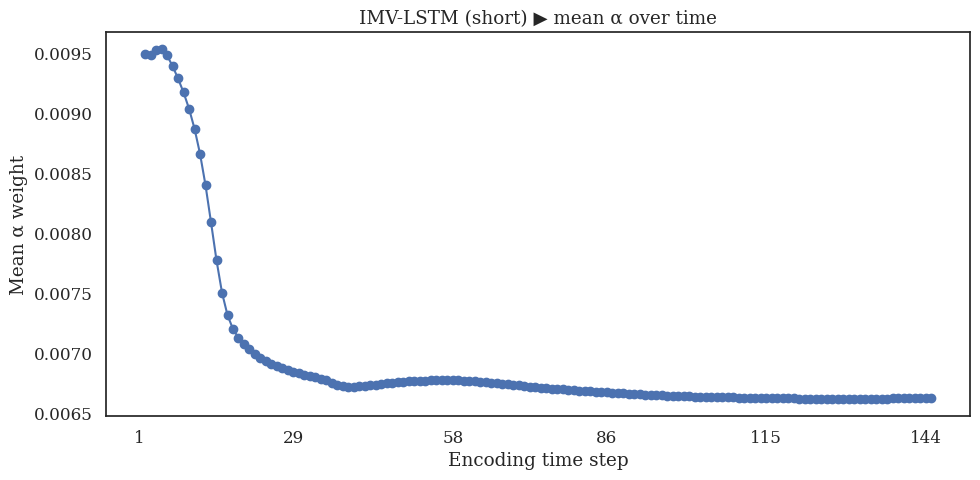

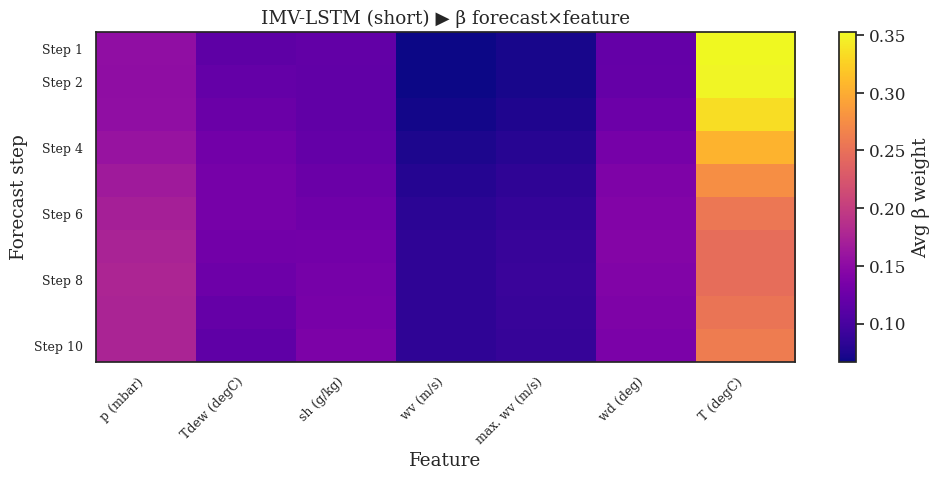

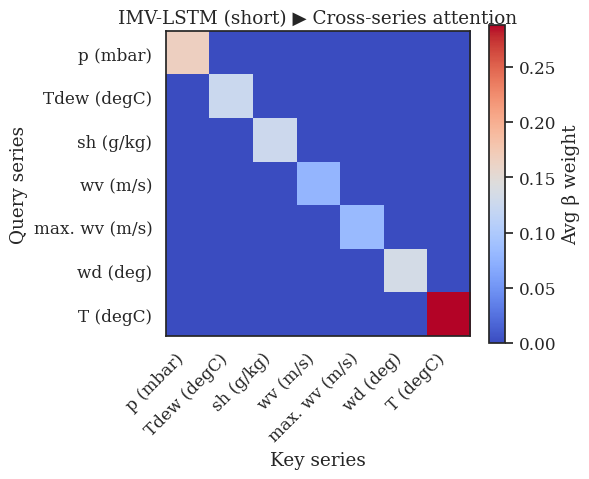

✓ saved cross-series attention plot → IMV_weather_144_10/attention_test\plots\IMV-LSTM_short_cross_series_attn.png


In [24]:
import importlib
import evaluation.attention_plots as perf      # bring in the module object
importlib.reload(perf) 
from evaluation.attention_plots import *
cols_weather_multi = [
    'p (mbar)', 'Tdew (degC)', 'sh (g/kg)',
    'wv (m/s)', 'max. wv (m/s)', 'wd (deg)',
    'T (degC)'
]



# 3) IMV-LSTM “short” attention plots
plot_imv_saved_attention(
    attn_dir      = "IMV_weather_144_10/attention_test",
    seq_len       = 144,
    pred_len      = 10,
    feature_names = cols_weather_multi,
    run_name      = "short"
)
plot_imv_cross_series(
    attn_dir      = "IMV_weather_144_10/attention_test",
    feature_names = cols_weather_multi,
    model_name    = "IMV-LSTM",
    run_name      = "short"
)

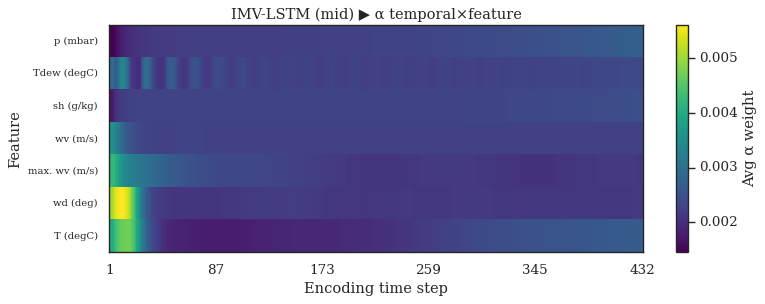

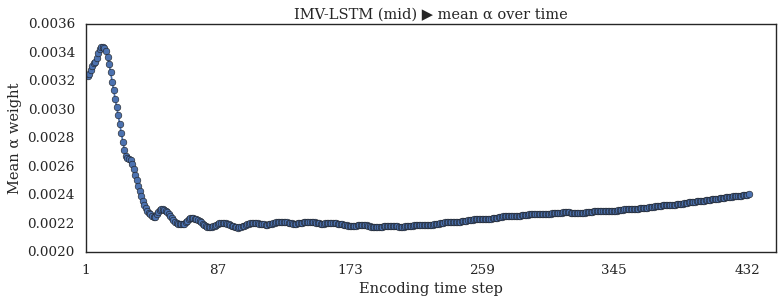

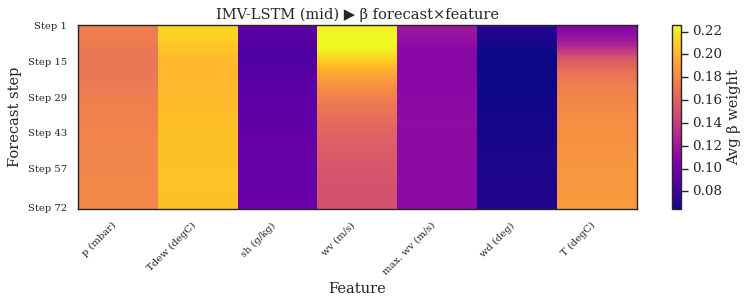

In [74]:
# 1) Re-define your feature list

plot_imv_saved_attention(
    attn_dir      = "IMV_weather_432_72/attention_test",
    seq_len       = 432,
    pred_len      = 72,
    feature_names = cols_weather_multi,
    run_name      = "mid"
)

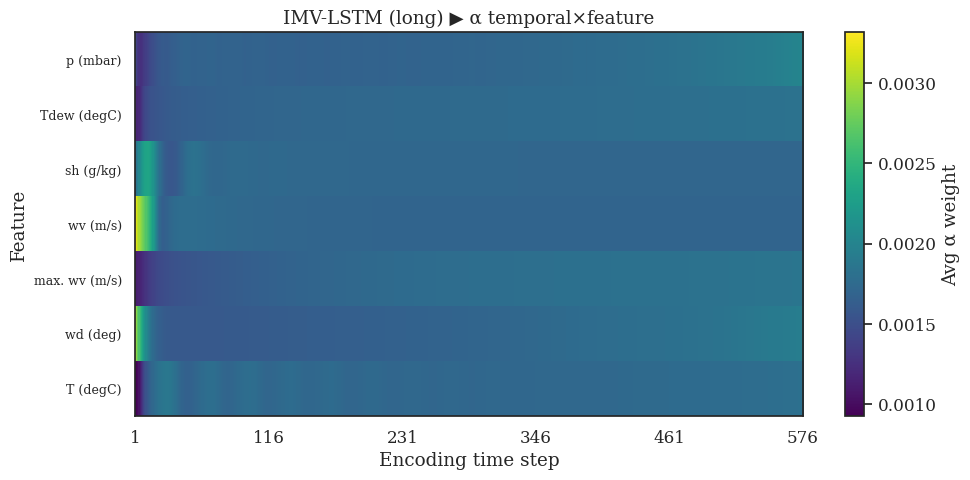

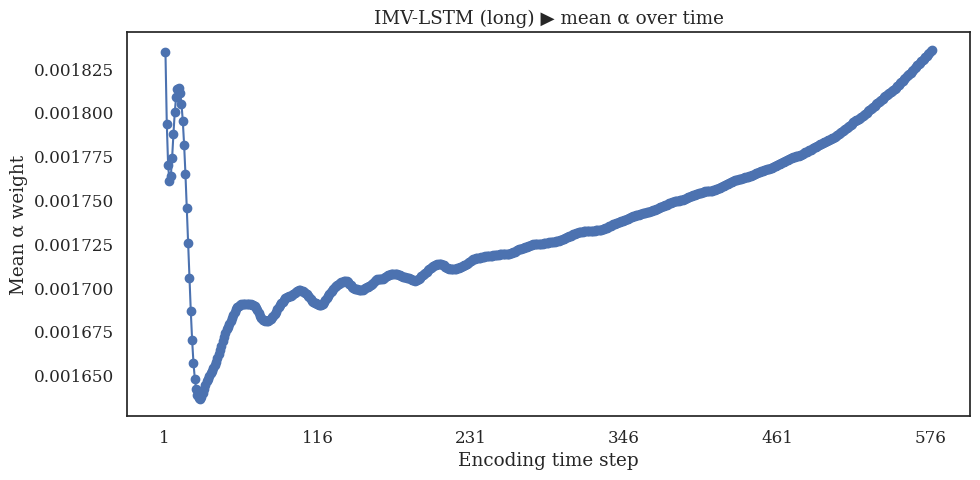

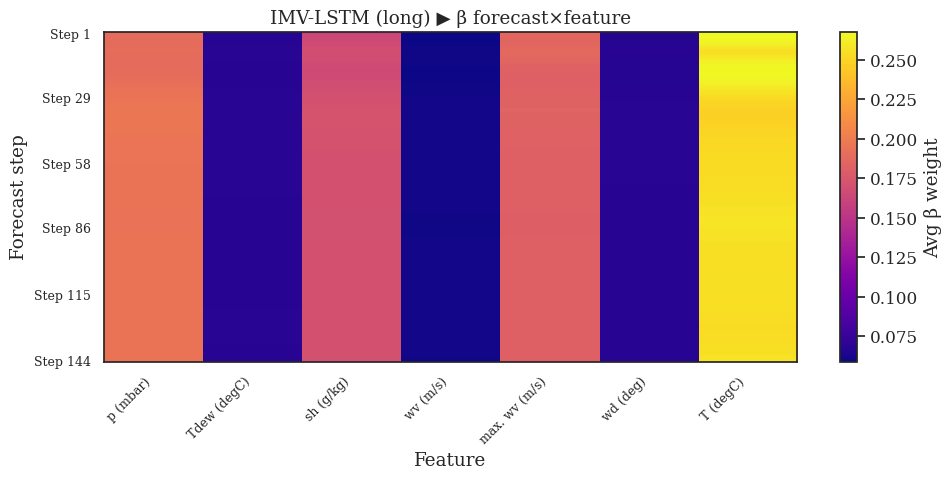

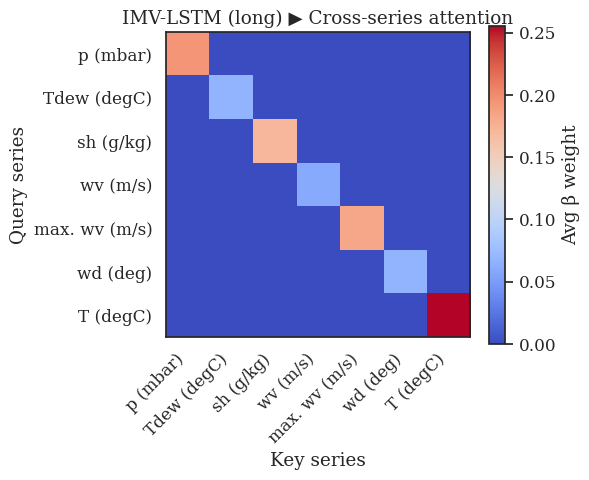

✓ saved cross-series attention plot → IMV_weather_576_144/attention_test\plots\IMV-LSTM_long_cross_series_attn.png


In [22]:
import importlib
import evaluation.attention_plots as perf      # bring in the module object
importlib.reload(perf) 
from evaluation.attention_plots import *
plot_imv_saved_attention(
    attn_dir      = "IMV_weather_576_144/attention_test",
    seq_len       = 576,
    pred_len      = 144,
    feature_names = cols_weather_multi,
    run_name      = "long"
)
plot_imv_cross_series(
    attn_dir      = "IMV_weather_576_144/attention_test",
    feature_names = cols_weather_multi,
    model_name    = "IMV-LSTM",
    run_name      = "long"
)

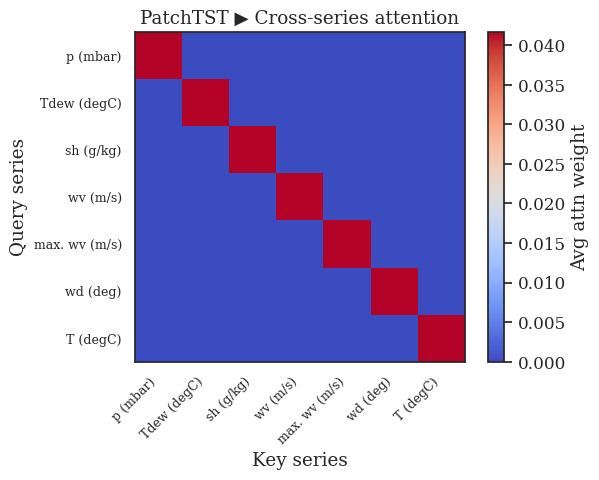

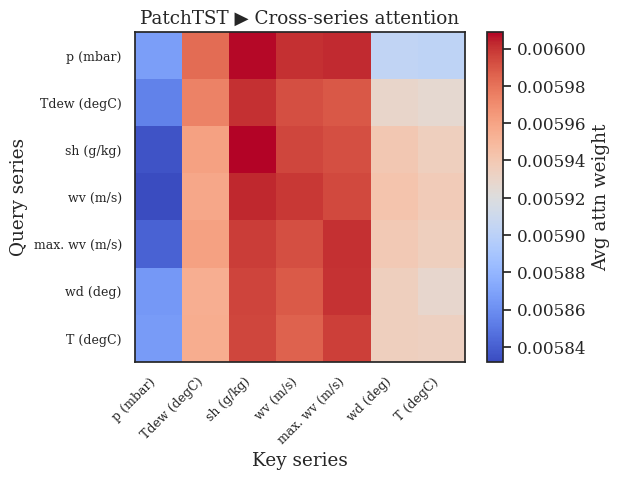

In [19]:
import importlib
import evaluation.attention_plots as perf      # bring in the module object
importlib.reload(perf) 
from evaluation.attention_plots import *
plot_patchtst_cross_series(
    attn_dir    = "test_results/weather_int_144_10_PatchTST/attn_maps",
    num_layers  = 3,
    num_batches = 81,                       # your batch count
    num_vars    = len(cols_weather_multi),  # 7
    num_heads   = 7,
    patch_num   = 24,
    feature_names = cols_weather_multi,
    model_name    = "PatchTST_Attention",
    run_name      = "mid"
)
plot_patchtst_cross_series(
    attn_dir    = "test_results/weather_int_144_10_PatchTST_shared/attn_maps",
    num_layers  = 3,
    num_batches = 81,                       # your batch count
    num_vars    = len(cols_weather_multi),  # 7
    num_heads   = 7,
    patch_num   = 24,
    feature_names = cols_weather_multi,
    model_name    = "PatchTST_Attention",
    run_name      = "mid-shared"
)

✅ Saved plots to test_results/weather_int_144_10_PatchTST/attn_maps\plots
Saved: test_results/weather_int_144_10_PatchTST/attn_maps\plots\PatchTST_CI_short_mean_patch_attention.png


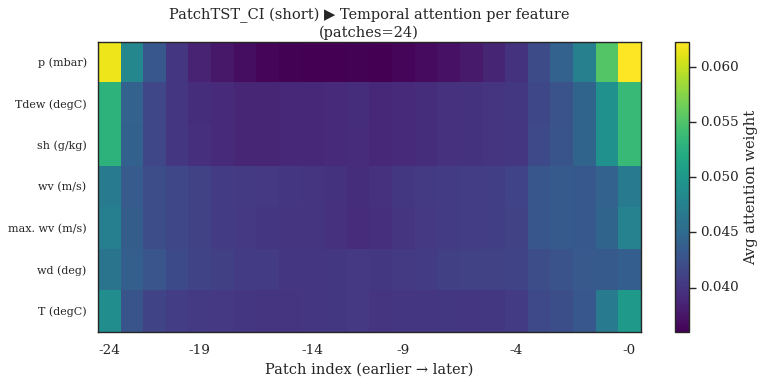

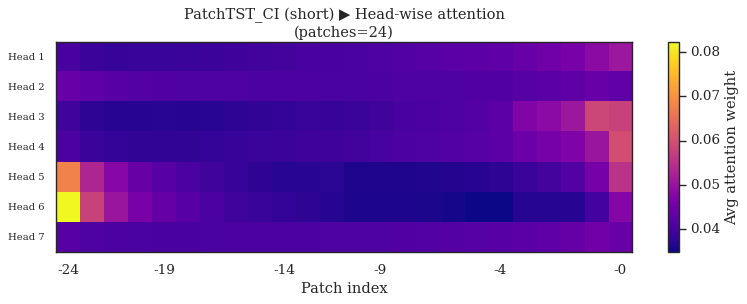

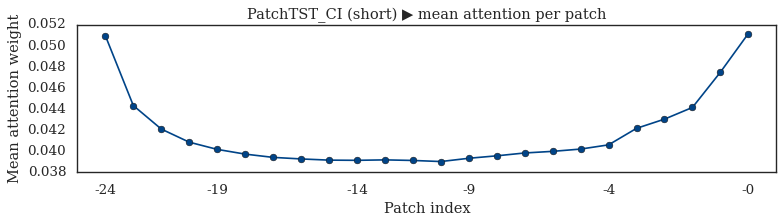

✅ Saved plots to test_results/weather_int_144_10_PatchTST_shared/attn_maps\plots
Saved: test_results/weather_int_144_10_PatchTST_shared/attn_maps\plots\PatchTST_CM_short-shared_mean_patch_attention.png


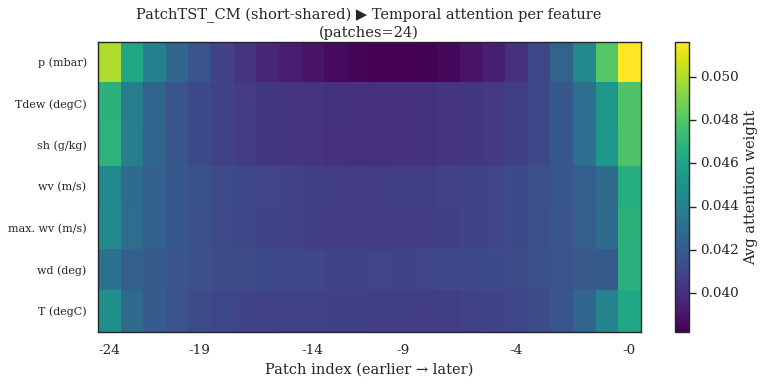

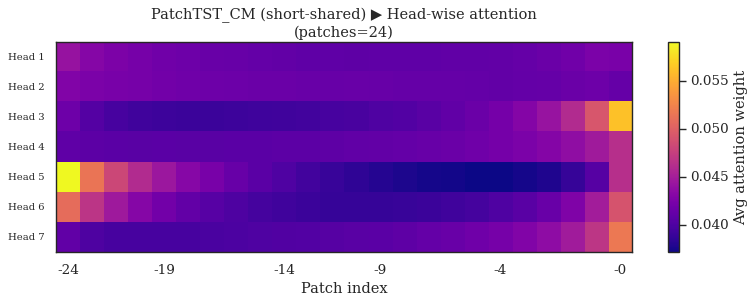

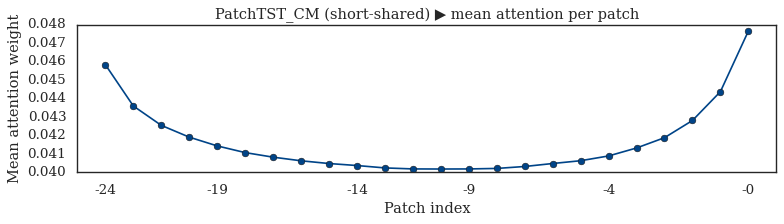

In [70]:
import importlib
import evaluation.attention_plots as perf      # bring in the module object
importlib.reload(perf) 
from evaluation.attention_plots import *
plot_patchtst_temporal(
    attn_dir    = "test_results/weather_int_144_10_PatchTST/attn_maps",
    num_layers  = 3,
    num_batches = 81,                       # your batch count
    num_vars    = len(cols_weather_multi),  # 7
    num_heads   = 7,
    feature_names = cols_weather_multi,
    model_name    = "PatchTST_CI",
    run_name      = "short"
)
plot_patchtst_temporal(
    attn_dir    = "test_results/weather_int_144_10_PatchTST_shared/attn_maps",
    num_layers  = 3,
    num_batches = 81,                       # your batch count
    num_vars    = len(cols_weather_multi),  # 7
    num_heads   = 7,
    feature_names = cols_weather_multi,
    model_name    = "PatchTST_CM",
    run_name      = "short-shared"
)

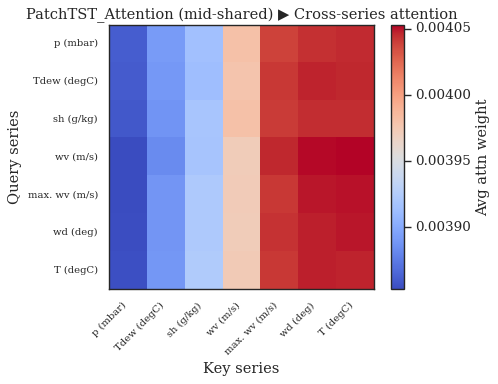

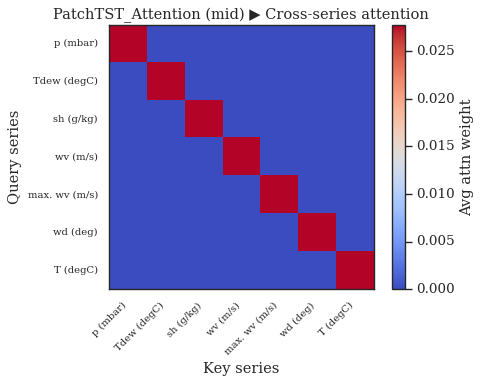

In [63]:

plot_patchtst_cross_series(
    attn_dir    = "test_results/weather_int_432_72_PatchTST_shared/attn_maps",
    num_layers  = 3,
    num_batches = 81,                       # your batch count
    num_vars    = len(cols_weather_multi),  # 7
    num_heads   = 7,
    patch_num   = 36,
    feature_names = cols_weather_multi,
    model_name    = "PatchTST_Attention",
    run_name      = "mid-shared"
)
plot_patchtst_cross_series(
    attn_dir    = "test_results/weather_int_432_72_PatchTST/attn_maps",
    num_layers  = 3,
    num_batches = 81,                       # your batch count
    num_vars    = len(cols_weather_multi),  # 7
    num_heads   = 7,
    patch_num   = 36,
    feature_names = cols_weather_multi,
    model_name    = "PatchTST_Attention",
    run_name      = "mid"
)

✅ Saved plots to test_results/weather_int_432_72_PatchTST/attn_maps\plots
Saved: test_results/weather_int_432_72_PatchTST/attn_maps\plots\PatchTST_Attention_mid_mean_patch_attention.png


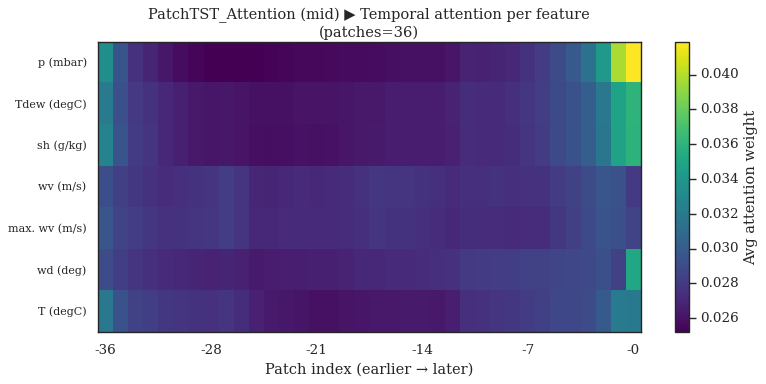

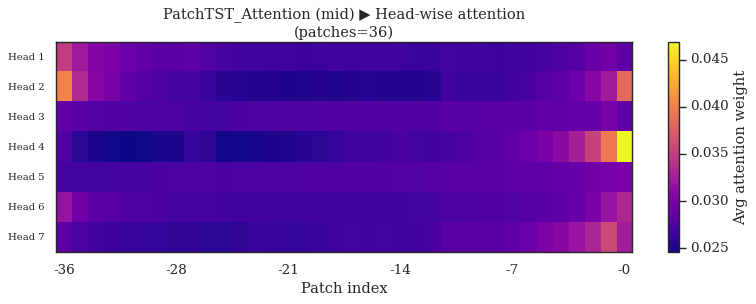

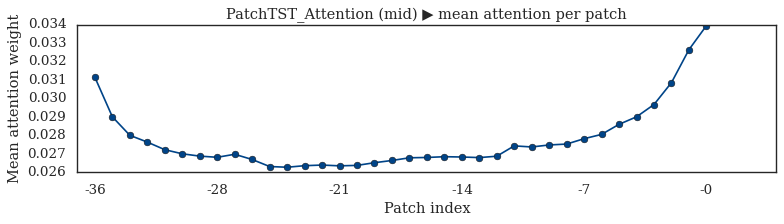

✅ Saved plots to test_results/weather_int_432_72_PatchTST_shared/attn_maps\plots
Saved: test_results/weather_int_432_72_PatchTST_shared/attn_maps\plots\PatchTST_Attention_mid-shared_mean_patch_attention.png


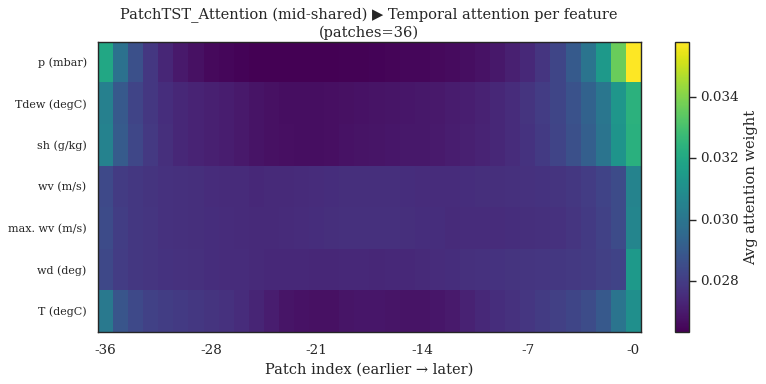

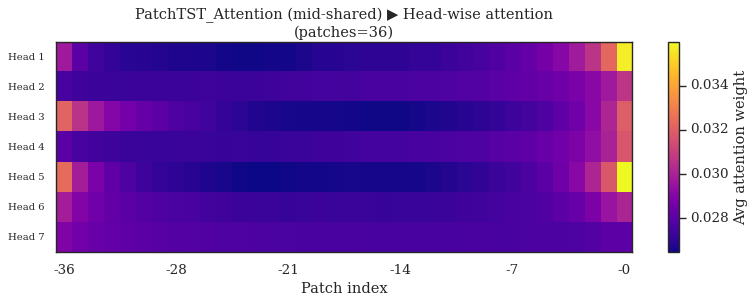

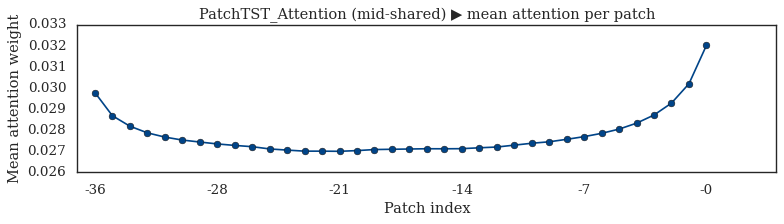

In [71]:
plot_patchtst_temporal(
    attn_dir    = "test_results/weather_int_432_72_PatchTST/attn_maps",
    num_layers  = 3,
    num_batches = 81,                       # your batch count
    num_vars    = len(cols_weather_multi),  # 7
    num_heads   = 7,
    feature_names = cols_weather_multi,
    model_name    = "PatchTST_Attention",
    run_name      = "mid"
)
plot_patchtst_temporal(
    attn_dir    = "test_results/weather_int_432_72_PatchTST_shared/attn_maps",
    num_layers  = 3,
    num_batches = 81,                       # your batch count
    num_vars    = len(cols_weather_multi),  # 7
    num_heads   = 7,
    feature_names = cols_weather_multi,
    model_name    = "PatchTST_Attention",
    run_name      = "mid-shared"
)

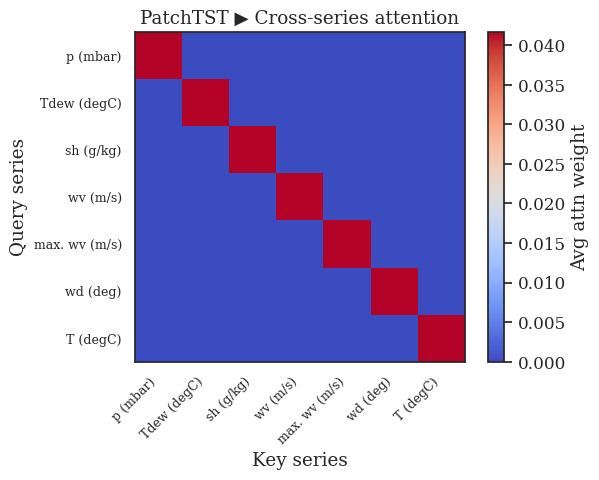

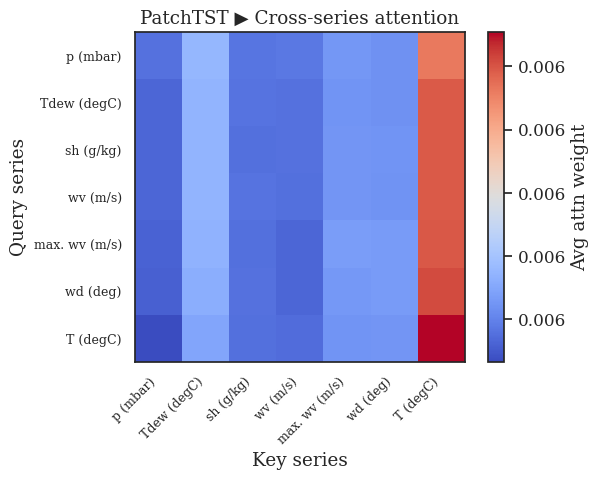

In [21]:
import importlib
import evaluation.attention_plots as perf      # bring in the module object
importlib.reload(perf) 
from evaluation.attention_plots import plot_patchtst_cross_series
plot_patchtst_cross_series(
    attn_dir    = "test_results/weather_int_576_144_PatchTST/attn_maps",
    num_layers  = 3,
    num_batches = 81,                       # your batch count
    num_vars    = len(cols_weather_multi),  # 7
    num_heads   = 7,
    patch_num   = 24,
    feature_names = cols_weather_multi,
    model_name    = "PatchTST_Attention",
    run_name      = "long"
)
plot_patchtst_cross_series(
    attn_dir    = "test_results/weather_int_576_144_PatchTST_shared/attn_maps",
    num_layers  = 3,
    num_batches = 81,                       # your batch count
    num_vars    = len(cols_weather_multi),  # 7
    num_heads   = 7,
    patch_num   = 24,
    feature_names = cols_weather_multi,
    model_name    = "PatchTST_Attention",
    run_name      = "long_shared"
)

✅ Saved plots to test_results/weather_int_576_144_PatchTST/attn_maps\plots
Saved: test_results/weather_int_576_144_PatchTST/attn_maps\plots\PatchTST_Attention_long_mean_patch_attention.png


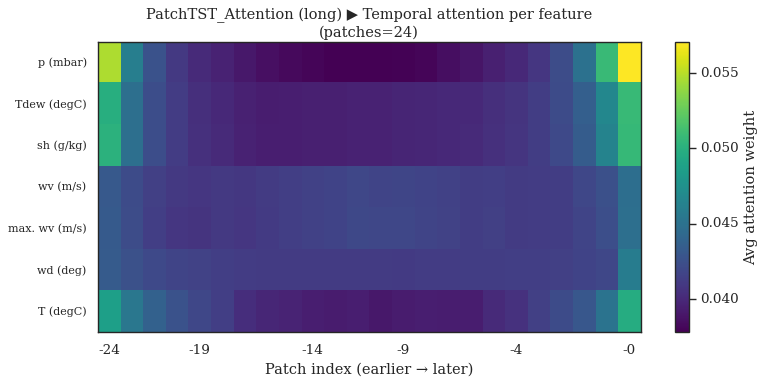

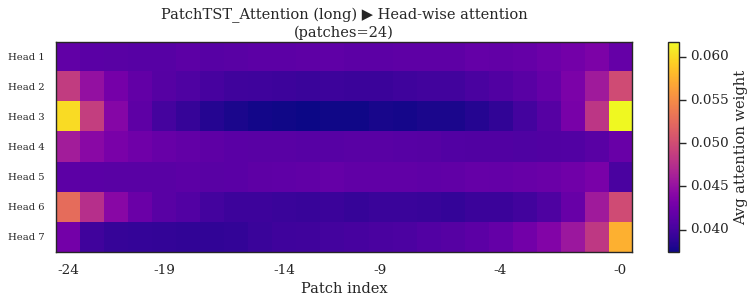

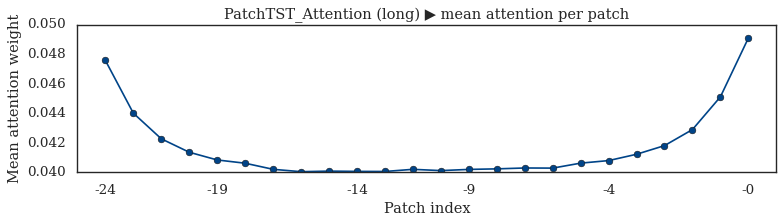

✅ Saved plots to test_results/weather_int_576_144_PatchTST_shared/attn_maps\plots
Saved: test_results/weather_int_576_144_PatchTST_shared/attn_maps\plots\PatchTST_Attention_long_mean_patch_attention.png


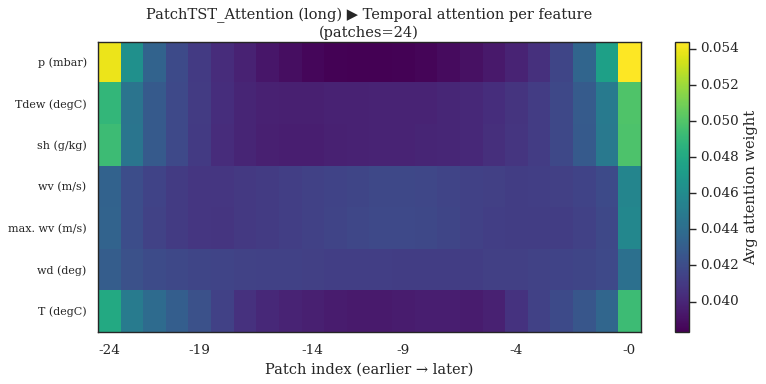

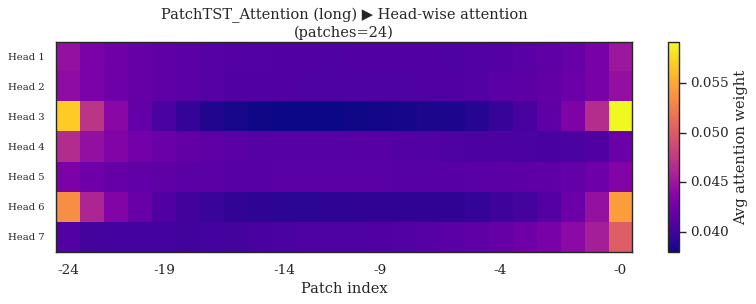

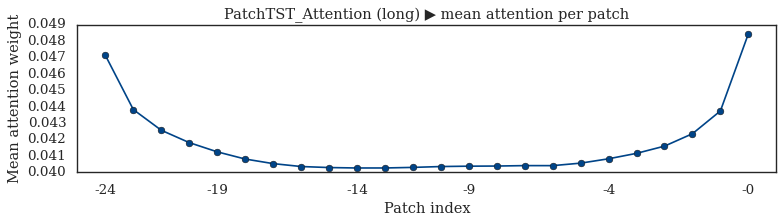

In [72]:
# 4) And for your “long” run (just swap to the long paths & lengths):
plot_patchtst_temporal(
    attn_dir      = "test_results/weather_int_576_144_PatchTST/attn_maps",
    num_layers  = 3,
    num_batches = 81,                       # your batch count
    num_vars    = len(cols_weather_multi),  # 7
    num_heads   = 7,
    feature_names = cols_weather_multi,
    model_name    = "PatchTST_Attention",
    run_name      = "long"
)
# 4) And for your “long” run (just swap to the long paths & lengths):
plot_patchtst_temporal(
    attn_dir      = "test_results/weather_int_576_144_PatchTST_shared/attn_maps",
    num_layers  = 3,
    num_batches = 81,                       # your batch count
    num_vars    = len(cols_weather_multi),  # 7
    num_heads   = 7,
    feature_names = cols_weather_multi,
    model_name    = "PatchTST_Attention",
    run_name      = "long"
)

### Randomisation PatchTST

In [32]:
# List out your two runs
restore_original_attention()

# 1) quick smoke check on one batch of the short model
xb, yb, *_ = next(iter(test_loader_patch))
xb = xb.to(device).float()
with torch.no_grad():
    out = model_patch(xb)
print("baseline short out shape:", out.shape)

enable_attention_randomization()
with torch.no_grad():
    out_r = model_patch(xb)
print("rand-attn short out shape:", out_r.shape)
disable_attention_randomization()

# 2) run full randomization tests on both
for name, m, loader, pred_len in [
    ("PatchTST-Short", model_patch,      test_loader_patch,      10),
    ("PatchTST-Mid", model_patch_mid,    test_loader_patch_mid,      72),
    ("PatchTST-Long",  model_patch_long, test_loader_patch_long, 144),
    ("PatchTST-Short-shared", model_patch_shared,      test_loader_patch,      10),
    ("PatchTST-Mid-shared", model_patch_mid_shared,    test_loader_patch_mid,      72),
    ("PatchTST-Long-shared",  model_patch_long_shared, test_loader_patch_long, 144),
]:
    print(f"\n=== {name} ===")
    orig_mse, rand_mse = patchtst_randomization_check(
        m, loader, device, pred_len=pred_len
    )
    print(f"orig MSE = {orig_mse:.4f}, rand MSE = {rand_mse:.4f}")

baseline short out shape: torch.Size([128, 10, 7])
rand-attn short out shape: torch.Size([128, 10, 7])

=== PatchTST-Short ===


rand-attn: 100%|███████████████████████████████████████████████████████████████████████| 83/83 [00:50<00:00,  1.64it/s]


orig MSE = 0.0055, rand MSE = 0.0113

=== PatchTST-Mid ===


rand-attn: 100%|███████████████████████████████████████████████████████████████████████| 82/82 [01:20<00:00,  1.02it/s]


orig MSE = 0.0592, rand MSE = 0.1146

=== PatchTST-Long ===


rand-attn: 100%|███████████████████████████████████████████████████████████████████████| 82/82 [01:07<00:00,  1.22it/s]


orig MSE = 0.0949, rand MSE = 0.1307

=== PatchTST-Short-shared ===


rand-attn: 100%|███████████████████████████████████████████████████████████████████████| 83/83 [01:27<00:00,  1.05s/it]


orig MSE = 0.0062, rand MSE = 0.0165

=== PatchTST-Mid-shared ===


rand-attn: 100%|███████████████████████████████████████████████████████████████████████| 82/82 [02:44<00:00,  2.01s/it]


orig MSE = 0.0604, rand MSE = 0.0760

=== PatchTST-Long-shared ===


rand-attn: 100%|███████████████████████████████████████████████████████████████████████| 82/82 [01:43<00:00,  1.26s/it]

orig MSE = 0.1071, rand MSE = 0.1159


### Randomization IMV-LSTM

In [33]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# assume you have two IMV-LSTM runs defined:
#   model_IMV_short, test_loader_IMV_short, pred_len=10
#   model_IMV_long,  test_loader_IMV_long,  pred_len=144

runs = [
    ("IMV-Short α-rand", model_IMV, test_loader_IMV, 10),
    ("IMV-Mid  α-rand", model_IMV_mid,  test_loader_IMV_mid, 72),
    ("IMV-Long  α-rand", model_IMV_long,  test_loader_IMV_long, 144),
    ("IMV-Short β-rand", model_IMV, test_loader_IMV, 10),
    ("IMV-Mid β-rand", model_IMV_mid, test_loader_IMV_mid, 72),
    ("IMV-Long  β-rand", model_IMV_long,  test_loader_IMV_long, 144),
]

for name, model, loader, pred_len in runs:
    model = model.float().to(device).eval()
    print(f"\n=== {name} (pred_len={pred_len}) ===")
    if "α" in name:
        orig, rand = imvlstm_attention_randomization_check(
            model, loader, device, target_channel=-1
        )
    else:
        orig, rand = imvlstm_beta_randomization_check(
            model, loader, device, target_channel=-1
        )
    print(f"orig MSE = {orig:.4f}, rand MSE = {rand:.4f}")



=== IMV-Short α-rand (pred_len=10) ===


IMV-LSTM rand-check: 100%|█████████████████████████████████████████████████████████████| 83/83 [02:40<00:00,  1.93s/it]


orig MSE = 0.0105, rand MSE = 0.0114

=== IMV-Mid  α-rand (pred_len=72) ===


IMV-LSTM rand-check: 100%|█████████████████████████████████████████████████████████████| 82/82 [08:35<00:00,  6.29s/it]


orig MSE = 0.1551, rand MSE = 0.2103

=== IMV-Long  α-rand (pred_len=144) ===


IMV-LSTM rand-check: 100%|█████████████████████████████████████████████████████████████| 82/82 [12:17<00:00,  9.00s/it]


orig MSE = 0.3156, rand MSE = 0.5176

=== IMV-Short β-rand (pred_len=10) ===


beta-rand-check: 100%|█████████████████████████████████████████████████████████████████| 83/83 [02:39<00:00,  1.92s/it]


orig MSE = 0.0105, rand MSE = 0.1540

=== IMV-Mid β-rand (pred_len=72) ===


beta-rand-check: 100%|█████████████████████████████████████████████████████████████████| 82/82 [08:33<00:00,  6.27s/it]


orig MSE = 0.1551, rand MSE = 0.1938

=== IMV-Long  β-rand (pred_len=144) ===


beta-rand-check: 100%|█████████████████████████████████████████████████████████████████| 82/82 [12:13<00:00,  8.94s/it]

orig MSE = 0.3156, rand MSE = 0.3184


In [44]:
from tqdm import tqdm
import numpy as np
import torch

def deletion_test(
    model,
    X: np.ndarray,
    y: np.ndarray,
    shap_times: np.ndarray,
    mask_value,
    fractions: np.ndarray,
    batch_size: int = 128,
    target_channel: int = -1,
    device=None,
):
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()

    N, L, V = X.shape
    _, H = y.shape[:2]

    # --- full-data preds ---
    all_preds, all_trues = [], []
    for i in tqdm(range(0, N, batch_size), desc="Full-data inference"):
        xb = torch.tensor(X[i:i+batch_size], device=device)
        with torch.no_grad():
            out = model(xb)
        if isinstance(out, tuple):
            out = out[0]
        out = out.cpu().numpy()
        # squeeze / pick target_channel
        if out.ndim == 3:
            if out.shape[2] == 1:
                out = out[...,0]
            else:
                out = out[..., target_channel]
        all_preds.append(out)

        yb = y[i:i+batch_size]
        if yb.ndim == 3 and yb.shape[2] == 1:
            yb = yb[...,0]
        all_trues.append(yb)

    preds_full = np.concatenate(all_preds, axis=0)  # (N,H)
    trues_full = np.concatenate(all_trues, axis=0)  # (N,H)

    mses = []
    for frac in fractions:
        k = int(np.floor(L * frac))
        to_mask = np.sort(shap_times[:k])

        Xm = X.copy()
        Xm[:, to_mask, :] = mask_value

        # masked preds
        m_preds = []
        for i in range(0, N, batch_size):
            xb = torch.tensor(Xm[i:i+batch_size], device=device)
            with torch.no_grad():
                out = model(xb)
            if isinstance(out, tuple):
                out = out[0]
            out = out.cpu().numpy()
            if out.ndim == 3:
                if out.shape[2] == 1:
                    out = out[...,0]
                else:
                    out = out[..., target_channel]
            m_preds.append(out)
        preds_mask = np.concatenate(m_preds, axis=0)

        # sanity print
        print(f"  frac={frac:.2f}: full {preds_full.shape} vs masked {preds_mask.shape}")

        # manual MSE on the overlapping portion
        Lmin = min(preds_full.size, preds_mask.size)
        mse  = np.mean((preds_full.ravel()[:Lmin] - preds_mask.ravel()[:Lmin])**2)
        mses.append(mse)

    return fractions, np.array(mses)


In [45]:
shap_vals = np.load("IMV_short_full_pruning_shap.npy")  # shape (144,)
shap_times = np.argsort(-shap_vals)

In [46]:
#shap_times = np.load("IMV_short_full_pruning_shap.npy")  # shape (144,)
fractions_shap, mses_shap = deletion_test(
    model = model_IMV,
    X     = X_test_multi.astype(np.float32),
    y     = y_test_multi.astype(np.float32),
    shap_times = shap_times,
    mask_value = X_test_multi.mean(axis=(0,1)),#per-feature mean
    fractions  = np.linspace(0,1,11),
    batch_size = 128,
    device     = device
)


Full-data inference: 100%|█████████████████████████████████████████████████████████████| 83/83 [01:22<00:00,  1.01it/s]


  frac=0.00: full (10509, 10) vs masked (10509, 10)
  frac=0.10: full (10509, 10) vs masked (10509, 10)
  frac=0.20: full (10509, 10) vs masked (10509, 10)
  frac=0.30: full (10509, 10) vs masked (10509, 10)
  frac=0.40: full (10509, 10) vs masked (10509, 10)
  frac=0.50: full (10509, 10) vs masked (10509, 10)
  frac=0.60: full (10509, 10) vs masked (10509, 10)
  frac=0.70: full (10509, 10) vs masked (10509, 10)
  frac=0.80: full (10509, 10) vs masked (10509, 10)
  frac=0.90: full (10509, 10) vs masked (10509, 10)
  frac=1.00: full (10509, 10) vs masked (10509, 10)


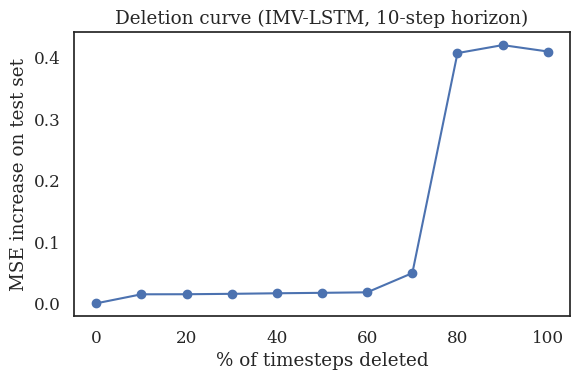

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.prop_cycle'] = cycler('color',
        ['#004488','#DDAA33','#BB5566','#66BBEE'])
sns.set_theme(style="white", palette="deep", font="serif", font_scale=1.1)
plt.figure(figsize=(6,4))
plt.plot(fractions_shap * 100, mses_shap, marker='o')
plt.xlabel("% of timesteps deleted")
plt.ylabel("MSE increase on test set")
plt.title("Deletion curve (IMV-LSTM, 10-step horizon)")
plt.grid(False)
plt.tight_layout()
plt.savefig('shap_MSE_IMV_short', dpi=300)
plt.show()


In [28]:
shap_vals_IMV_long = np.load("IMV_long_full_pruning_shap.npy")  # shape (144,)
shap_times_long = np.argsort(-shap_vals_IMV_long)

In [29]:
fractions_shap_long, mses_shap_long = deletion_test(
    model = model_IMV_long,
    X     = X_test_long.astype(np.float32),
    y     = y_test_long.astype(np.float32),
    shap_times = shap_times_long,
    mask_value = X_test_long.mean(axis=(0,1)),#per-feature mean
    fractions  = np.linspace(0,1,11),
    batch_size = 128,
    device     = device
)

Full-data inference: 100%|█████████████████████████████████████████████████████████████| 82/82 [06:35<00:00,  4.82s/it]


  frac=0.00: full (10396, 144) vs masked (10396, 144)
  frac=0.10: full (10396, 144) vs masked (10396, 144)
  frac=0.20: full (10396, 144) vs masked (10396, 144)
  frac=0.30: full (10396, 144) vs masked (10396, 144)
  frac=0.40: full (10396, 144) vs masked (10396, 144)
  frac=0.50: full (10396, 144) vs masked (10396, 144)
  frac=0.60: full (10396, 144) vs masked (10396, 144)
  frac=0.70: full (10396, 144) vs masked (10396, 144)
  frac=0.80: full (10396, 144) vs masked (10396, 144)
  frac=0.90: full (10396, 144) vs masked (10396, 144)
  frac=1.00: full (10396, 144) vs masked (10396, 144)


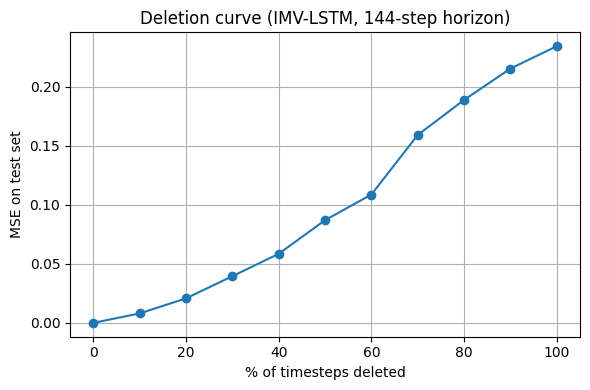

In [31]:
plt.figure(figsize=(6,4))
plt.plot(fractions_shap_long * 100, mses_shap_long, marker='o')
plt.xlabel("% of timesteps deleted")
plt.ylabel("MSE on test set")
plt.title("Deletion curve (IMV-LSTM, 144-step horizon)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
imv_times = np.load("./IMV_weather_144_10/attention_test/plots/IMV-LSTM_short_mean_alpha.npy")  # shape (144,)
imv_times_attention = np.argsort(-imv_times)
fractions_imv, mses_imv = deletion_test(
    model           = model_IMV,
    X               = X_test_multi.astype(np.float32),
    y               = y_test_multi.astype(np.float32),
    shap_times      = imv_times_attention,
    mask_value      = X_test_multi.mean(axis=(0,1)).astype(np.float32),
    fractions       = np.linspace(0,1,11),
    batch_size      = 128,
    device          = device,
)


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(fractions_imv*100, mses_imv, marker='o')
plt.title(f"Deletion curve (IMV_LSTM - lpha attention)")
plt.xlabel("% of timesteps deleted")
plt.ylabel("MSE")
plt.grid(False)
plt.show()


In [51]:
# 1) load your pre‐computed ranking
times_patch = np.load("patch_short_full_pruning_shap.npy")  # (seq_len,)
times_patch_attention = np.argsort(-times_patch)
# 2) build Xp, y_test_patch
Xp_list, yp_list = [], []
for xb, yb, xb_m, yb_m in test_loader_patch:
    Xp_list.append(xb.numpy())  # xb: (B, seq_len, V)
    yp_list.append(yb.numpy())  # yb: (B, pred_len, 1)

Xp = np.concatenate(Xp_list, axis=0).astype(np.float32)   # (N, seq_len, V)
y_test_patch = np.concatenate(yp_list, axis=0).astype(np.float32)  # (N, pred_len, 1)
y_test_patch = y_test_patch[:, -10:, 0]  # now (N, 10)

# 3) mask value per‐feature
mask_patch = Xp.mean(axis=(0,1)).astype(np.float32)   # (V,)

# 4) run deletion test
fractions_patch, mses_patch = deletion_test(
    model           = model_patch,
    X               = Xp,                   # (N, L, V)
    y               = y_test_patch,         # (N, H, 1) or (N,H)
    shap_times      = times_patch_attention,
    mask_value      = mask_patch.astype(np.float32),
    fractions       = np.linspace(0,1,11),
    batch_size      = 128,
    target_channel  = -1,                   # pick the only channel
    device          = device,
)

# 5) plot
import matplotlib.pyplot as plt


Full-data inference: 100%|█████████████████████████████████████████████████████████████| 83/83 [00:47<00:00,  1.74it/s]


  frac=0.00: full (10530, 10) vs masked (10530, 10)
  frac=0.10: full (10530, 10) vs masked (10530, 10)
  frac=0.20: full (10530, 10) vs masked (10530, 10)
  frac=0.30: full (10530, 10) vs masked (10530, 10)
  frac=0.40: full (10530, 10) vs masked (10530, 10)
  frac=0.50: full (10530, 10) vs masked (10530, 10)
  frac=0.60: full (10530, 10) vs masked (10530, 10)
  frac=0.70: full (10530, 10) vs masked (10530, 10)
  frac=0.80: full (10530, 10) vs masked (10530, 10)
  frac=0.90: full (10530, 10) vs masked (10530, 10)
  frac=1.00: full (10530, 10) vs masked (10530, 10)


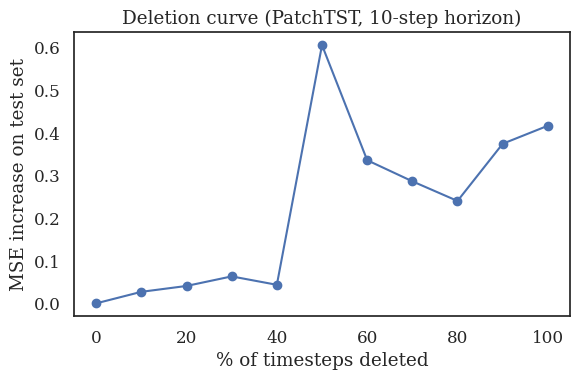

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.prop_cycle'] = cycler('color',
        ['#004488','#DDAA33','#BB5566','#66BBEE'])
sns.set_theme(style="white", palette="deep", font="serif", font_scale=1.1)
plt.figure(figsize=(6,4))
plt.plot(fractions_patch*100, mses_patch, marker='o')
plt.xlabel("% of timesteps deleted")
plt.ylabel("MSE increase on test set")
plt.title("Deletion curve (PatchTST, 10-step horizon)")
plt.grid(False)
plt.tight_layout()
plt.savefig('shap_MSE_PatchTST_short', dpi=300)
plt.show()


Full-data inference: 100%|█████████████████████████████████████████████████████████████| 82/82 [01:33<00:00,  1.14s/it]


  frac=0.00: full (10396, 144) vs masked (10396, 144)
  frac=0.10: full (10396, 144) vs masked (10396, 144)
  frac=0.20: full (10396, 144) vs masked (10396, 144)
  frac=0.30: full (10396, 144) vs masked (10396, 144)
  frac=0.40: full (10396, 144) vs masked (10396, 144)
  frac=0.50: full (10396, 144) vs masked (10396, 144)
  frac=0.60: full (10396, 144) vs masked (10396, 144)
  frac=0.70: full (10396, 144) vs masked (10396, 144)
  frac=0.80: full (10396, 144) vs masked (10396, 144)
  frac=0.90: full (10396, 144) vs masked (10396, 144)
  frac=1.00: full (10396, 144) vs masked (10396, 144)


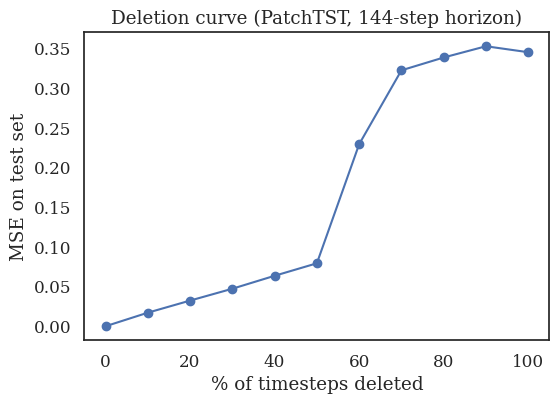

In [53]:
# 1) load your pre‐computed ranking
times_patch_long = np.load("patch_long_shared_full_pruning_shap.npy")  # (seq_len,)
times_patch_long_attention = np.argsort(-times_patch_long)
# 2) build Xp, y_test_patch
Xp_list_long, yp_list_long = [], []
for xb, yb, xb_m, yb_m in test_loader_patch_long:
    Xp_list_long.append(xb.numpy())  # xb: (B, seq_len, V)
    yp_list_long.append(yb.numpy())  # yb: (B, pred_len, 1)

Xp_long = np.concatenate(Xp_list_long, axis=0).astype(np.float32)   # (N, seq_len, V)
y_test_patch_long = np.concatenate(yp_list_long, axis=0).astype(np.float32)  # (N, pred_len, 1)
y_test_patch_long = y_test_patch_long[:, -72:, 0]  # now (N, 10)

# 3) mask value per‐feature
mask_patch_long = Xp_long.mean(axis=(0,1)).astype(np.float32)   # (V,)

# 4) run deletion test
fractions_patch_long, mses_patch_long = deletion_test(
    model           = model_patch_long_shared,
    X               = Xp_long,                   # (N, L, V)
    y               = y_test_patch_long,         # (N, H, 1) or (N,H)
    shap_times      = times_patch_long_attention,
    mask_value      = mask_patch_long.astype(np.float32),
    fractions       = np.linspace(0,1,11),
    batch_size      = 128,
    target_channel  = -1,                   # pick the only channel
    device          = device,
)

# 5) plot
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(fractions_patch_long*100, mses_patch_long, marker='o')
plt.title("Deletion curve (PatchTST, 144-step horizon)")
plt.xlabel("% of timesteps deleted")
plt.ylabel("MSE on test set")
plt.grid(False)
plt.show()


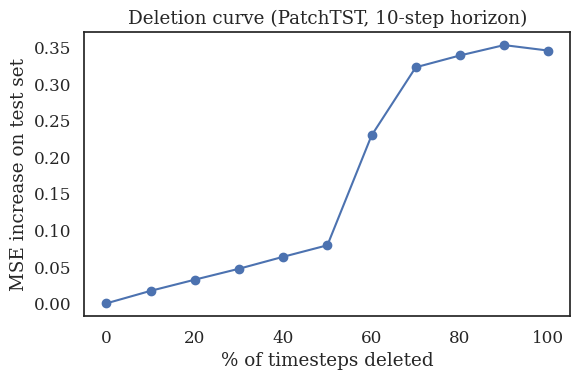

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.prop_cycle'] = cycler('color',
        ['#004488','#DDAA33','#BB5566','#66BBEE'])
sns.set_theme(style="white", palette="deep", font="serif", font_scale=1.1)
plt.figure(figsize=(6,4))
plt.plot(fractions_patch_long*100, mses_patch_long, marker='o')
plt.xlabel("% of timesteps deleted")
plt.ylabel("MSE increase on test set")
plt.title("Deletion curve (PatchTST, 10-step horizon)")
plt.grid(False)
plt.tight_layout()
plt.savefig('shap_MSE_PatchTST_shared_short', dpi=300)
plt.show()


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def temporal_grad_cam(model, 
                      inputs: torch.Tensor, 
                      layer_name: str, 
                      target_step: int = 0, 
                      baseline: float = 0.0, 
                      device: torch.device = torch.device('cpu')):
    """
    Compute a temporal Grad-CAM for a PyTorch forecasting model.
    
    Args:
      model: your PyTorch model (e.g., IMV-LSTM or PatchTST)
      inputs: Tensor of shape (1, seq_len, num_features)
      layer_name: name of the layer to probe (string)
      target_step: which forecast step (0-based) to explain
      baseline: value to fill in for masked inputs if needed
      device: torch device
    
    Returns:
      grad_cam: numpy array of shape (seq_len,) with importance per time-step
    """
    model.eval()
    inputs = inputs.to(device).requires_grad_(True)
    
    # 1. Extract the intermediate activations
    activations = None
    gradients = None
    
    def forward_hook(module, inp, out):
        nonlocal activations
        activations = out  # expecting shape (1, seq_len, D)
    
    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]  # same shape as activations
    
    # register hooks
    layer = dict(model.named_modules())[layer_name]
    h_f = layer.register_forward_hook(forward_hook)
    h_b = layer.register_backward_hook(backward_hook)
    
    # 2. Forward pass
    output = model(inputs)  # shape (1, H, 1) or (1, H) or (1, H, F)
    # select the target forecast step
    if output.ndim == 3 and output.shape[-1] == 1:
        score = output[0, target_step, 0]
    else:
        score = output[0, target_step]
    
    # 3. Backward pass
    model.zero_grad()
    score.backward(retain_graph=True)
    
    # remove hooks
    h_f.remove()
    h_b.remove()
    
    # 4. Compute weights: average gradients over feature dim
    # activations: (1, seq_len, D); gradients same
    grads = gradients.detach().cpu().numpy()[0]    # (seq_len, D)
    acts  = activations.detach().cpu().numpy()[0]  # (seq_len, D)
    weights = np.mean(grads, axis=1)              # (seq_len,)
    
    # 5. Compute per-time importance: weighted sum over D
    cam = np.sum(acts * weights[:, np.newaxis], axis=1)  # (seq_len,)
    cam = np.maximum(cam, 0)  # ReLU
    
    # 6. Normalize for visualization
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    return cam

# Example usage:
# model = model_IMV  # or PatchTST instance
# x = X_val_t_multi[0:1]  # single example
# cam = temporal_grad_cam(model, x, layer_name='lstm_layer', target_step=0, device=device)
# plt.plot(cam); plt.title('Temporal Grad-CAM'); plt.xlabel('Time step'); plt.ylabel('Importance'); plt.show()



## Timeshap

### train loaders

In [20]:
# 1) Instantiate your test‐time dataset exactly as during training
dataset_train_patch_short = Dataset_Custom(
    root_path   = "dataset/",
    flag        = "train",                 # pulls the test split
    size        = [144, 10, 10],          # [seq_len, label_len, pred_len]
    features    = "MS",
    data_path   = "weather_int.csv",
    target      = "T (degC)",
    scale       = True,
    timeenc     = 0,
    freq        = "10T",
)

# 2) Wrap in a DataLoader
train_loader_patch_short = DataLoader(
    dataset_train_patch_short,
    batch_size  = 128,
    shuffle     = False,
    num_workers = 0,
)


In [21]:
# 1) Instantiate your long-horizon test dataset exactly as during training
dataset_train_patch_long = Dataset_Custom(
    root_path   = "dataset/",           # relative to cwd
    flag        = "train",               # pulls the test split
    size        = [576, 144, 144],      # [seq_len, label_len, pred_len]
    features    = "MS",
    data_path   = "weather_int.csv",
    target      = "T (degC)",
    scale       = True,
    timeenc     = 0,
    freq        = "10T",
)

# 2) Wrap in a DataLoader
train_loader_patch_long = DataLoader(
    dataset_train_patch_long,
    batch_size  = 128,
    shuffle     = False,
    num_workers = 0,
)


In [22]:
dataset_train_patch_mid = Dataset_Custom(
    root_path   = "dataset/",           # relative to cwd
    flag        = "train",               # pulls the test split
    size        = [432, 72, 72],      # [seq_len, label_len, pred_len]
    features    = "MS",
    data_path   = "weather_int.csv",
    target      = "T (degC)",
    scale       = True,
    timeenc     = 0,
    freq        = "10T",
)

# 2) Wrap in a DataLoader
train_loader_patch_mid = DataLoader(
    dataset_train_patch_mid,
    batch_size  = 128,
    shuffle     = False,
    num_workers = 0,
)

In [23]:
##long
# 4) Tensor‐ify
X_train_t_long = torch.tensor(X_train_long, dtype=torch.float32)
y_train_t_long = torch.tensor(y_train_long, dtype=torch.float32)

# 5) Long‐horizon test DataLoader
train_loader_IMV_long = DataLoader(
    TensorDataset(X_train_t_long, y_train_t_long),
    shuffle     = False,
    batch_size  = batch_size_weather,
    num_workers = 0
)
##mid
# 4) Tensor‐ify
X_train_t_mid = torch.tensor(X_train_mid, dtype=torch.float32)
y_train_t_mid = torch.tensor(y_train_mid, dtype=torch.float32)

# 5) Long‐horizon test DataLoader
train_loader_IMV_mid = DataLoader(
    TensorDataset(X_train_t_mid, y_train_t_mid),
    shuffle     = False,
    batch_size  = batch_size_weather,
    num_workers = 0
)
# 4) Tensor‐ify
X_train_t_short = torch.tensor(X_train_multi, dtype=torch.float32)
y_train_t_short = torch.tensor(y_train_multi, dtype=torch.float32)

# 5) Long‐horizon test DataLoader
train_loader_IMV_short = DataLoader(
    TensorDataset(X_train_t_short, y_train_t_short),
    shuffle     = False,
    batch_size  = batch_size_weather,
    num_workers = 0
)

In [ ]:
import importlib
import evaluation.timeshap as tshap      # bring in the module object
importlib.reload(tshap)                  # re‐read it from disk
from evaluation.timeshap import explain_model_window, explain_with_chunks
dataset_test_IMV_mid=TensorDataset(X_test_t_mid, y_test_t_mid)
dataset_test_IMV_long=TensorDataset(X_test_t_long, y_test_t_long)
dataset_test_IMV_short=TensorDataset(X_test_t_multi, y_test_t_multi)
experiments_IMV_1 = [
{
        "model":           model_IMV,
        "train_loader":    train_loader_IMV_short,
        "test_dataset":    dataset_test_IMV_short,
        "seq_len":         144,
        "out_prefix":      "IMV_short",
    },
    {
        "model":           model_IMV_mid,
        "train_loader":    train_loader_IMV_mid,
        "test_dataset":    dataset_test_IMV_mid,
        "seq_len":         432,
        "out_prefix":      "IMV_mid",
    },
    ]
# ─── Run explanations ─────────────────────────────────────────────────────────
results_IMV_1 = {}
for exp in experiments_IMV_1:
    print(f">>> Explaining {exp['out_prefix']} …")
    results[exp['out_prefix']] = explain_with_chunks(
        **exp,
        chunk_thresh=40   # windows of 40 steps
    )

>>> Explaining IMV_short …
>>> Explaining IMV_mid …
>>> Explaining chunk 1/11: [0:40] …


In [ ]:
experiments_IMV_2 = [
    {
        "model":           model_IMV_long,
        "train_loader":    train_loader_IMV_long,
        "test_dataset":    dataset_test_IMV_long,
        "seq_len":         576,
        "out_prefix":      "IMV_long",
    },
    ]
# ─── Run explanations ─────────────────────────────────────────────────────────
results = {}
for exp in experiments_IMV_2:
    print(f">>> Explaining {exp['out_prefix']} …")
    results[exp['out_prefix']] = explain_with_chunks(
        **exp,
        chunk_thresh=40   # windows of 40 steps
    )

In [ ]:
import importlib
import evaluation.timeshap as tshap      # bring in the module object
importlib.reload(tshap)                  # re‐read it from disk
from evaluation.timeshap import explain_model_window, explain_with_chunks
   # rebind the updated function

# ─── Define your experiments ──────────────────────────────────────────────────
experiments = [
    {
        "model":           model_patch,
        "train_loader":    train_loader_patch_short,
        "test_dataset":    dataset_test,
       "seq_len":         40,
        "out_prefix":      "patch_short",
    },
 
    {
        "model":           model_patch_mid,
        "train_loader":    train_loader_patch_mid,
        "test_dataset":    dataset_test_patch_mid,
        "seq_len":         432,
        "out_prefix":      "patch_mid",
    },

    {
        "model":           model_patch_long,
        "train_loader":    train_loader_patch_long,
        "test_dataset":    dataset_test_patch_long,
        "seq_len":         576,
        "out_prefix":      "patch_long",
    },

]

# ─── Run explanations ─────────────────────────────────────────────────────────
# make sure you have your wrapper in scope
# from timeshap_wrapper import explain_with_chunks   # wherever you put it

results_patch = {}
for exp in experiments:
    print(f">>> Explaining {exp['out_prefix']} …")
    results[exp['out_prefix']] = explain_with_chunks(
        **exp,
        chunk_thresh=40   # windows of 40 steps
    )




In [ ]:
!pip freeze > requirements.txt


In [ ]:
chart1, chart2, chart3 = results["charts"]
chart1   # displays the pruning chart
chart2   # displays the event‐level heatmap
chart3   # displays the feature‐level barplot


In [ ]:
pruning_df, num_kept = local_pruning(
    f_last,        # your numpy‐wrapped model → (N,1)
    x_test,        # shape (1, seq_len, n_feat)
    pruning_dict,  # {"tol":…, "nsamples":…}
    background,    # baseline sequences, shape (M, seq_len, n_feat)
    verbose=True   # you can skip entity_uuid/col (they default to None)
)


In [ ]:

# ─── 6a) Plot the pruning result ───────────────────────────────────────────────
plot_temp_coalition_pruning(pruning_df, num_kept)

In [ ]:
# ─── 6b) Event-level explanation ───────────────────────────────────────────────
event_dict = {
    "rs":       2021,  # random seed for SHAP sampling
    "nsamples": 200
}
ev_expl = local_event(
    f_last,
    x_test,
    event_dict,
    None,         # entity_uuid (not used here)
    None,         # entity_col  (not used here)
    background,   # baseline
    num_kept      # pruned_idx
)
plot_event_heatmap(ev_expl)

In [ ]:
# ─── 6c) Feature-level explanation ─────────────────────────────────────────────
feat_dict = {
    "rs":       2021,
    "nsamples": 200
}
ft_expl = local_feat(
    f_last,
    x_test,
    feat_dict,
    None,
    None,
    background,
    num_kept
)
plot_feat_barplot(ft_expl)